In [1]:
#TODO Main Tasks
# Running NOW: Retrain only with ReLU and verify with Marabou


# Use Marabou to verify global robustness or areas of local robustness if the global robustness doesn't work.
# The network doesn't take time series as input, so time series input analysis seems like it's unrelated to this project
# but we can come up with something.

In [2]:
import matplotlib
#matplotlib.use('Agg') # If we don't want saved images printed on output

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import time

from Models.loss import smoothL1

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, InputLayer
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

import math
import io
import os
from collections import namedtuple
import sys
from sklearn import tree
from tqdm import tqdm
import operator
import pandas as pd

import copy
import glob

#from vis.visualization import visualize_cam
#import cv2
#FIXIT Needs old Scipy version (1.1.0), need to check integration with Conda and Pip

#import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

In [3]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
from io import StringIO
from io import BytesIO

In [4]:
from tf_keras_vis.utils import num_of_gpus

from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

2 GPUs


In [5]:
"""
Augmentation System
By: Tyler Staudinger
Using CPU based augmentation from a dataset loaded into memory incurs about 10% additional per epoch 
processing time
Copyright 2018 The Boeing Company
"""

from imgaug import augmenters as iaa
import numpy as np
import cv2

#Apply various augmentations from imgaug
def blur():
    blurer=[iaa.GaussianBlur((0, 3.0)),iaa.AverageBlur(k=(2, 7)),iaa.MedianBlur(k=(3, 11))]
    return blurer[np.random.randint(0,3)]

#Dropout may not be appropriate, so its not currently used
def dropout():
    dropper=[iaa.Dropout((0.01, 0.1), per_channel=0.5), iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2)]
    return dropper[np.random.randint(0,2)]

def noise():
    return iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)

def contrast():
    return iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)

def greyscale():
    return iaa.Grayscale(alpha=(0.0, 1.0))

def invert():
    return iaa.Invert(0.05, per_channel=True)

def hue():
    return iaa.AddToHueAndSaturation((-20, 20))

def add(): 
    return iaa.Add((-10, 10), per_channel=0.5)

def multiply():
    return iaa.Multiply((0.5, 1.5), per_channel=0.5)

def sharpen(): 
    return iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))

def emboss(): 
    return iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))
   
def translate():
    return iaa.Affine(translate_percent={"x": (0.0, 0.0), "y": (-0.03, 0.03)},mode='edge')
    
def rotate():
    return iaa.Affine(rotate=(-3, 3),mode='edge')    

   
def augment(imgs,max_augs,affine=False,debug=False):
    """Applys a series of augmentations to an image
    # Arguments
        imgs: the input images
        max_augs: the maximum number of augmentations to apply
    # Returns
        Augmented images
    """
    augmented=[]
    for img in imgs:
        if affine:
            affine_augs=[translate(),rotate()]            
            seq_affine=iaa.Sequential(affine_augs)
            img=seq_affine.augment_image(img)
        #Choose a number of augmentations to use
        num_aug=np.random.randint(0,max_augs+1)
        #set of augmentations to use
        augs=[blur(),noise(),contrast(),greyscale(),invert(),hue(),add(),multiply(),sharpen(),emboss()]
        #apply augmentations
        seq=iaa.Sequential(list(np.random.choice(augs,num_aug)))
        aug_img=seq.augment_image(img)
        
        #For Debugging of augmentations
        if debug:
            cv2.imshow('frame',aug_img)
            cv2.waitKey(1000)
        augmented.append(aug_img)
        
    return np.asarray(augmented)
    
    
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, noaugs=False, num_aug=5, affine=False, height=None, width=None): 
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.noaugs     = noaugs
        self.num_aug    = num_aug
        self.affine     = affine
        self.height     = height
        self.width      = width
        
    def __getitem__(self, idx):
        
        #indecies=np.random.randint(0,self.X.shape[0],self.batch_size)
            
        if self.noaugs:
            images=self.X[idx * self.batch_size:(idx + 1) *self.batch_size]/255.0
            target=self.y[idx * self.batch_size:(idx + 1) *self.batch_size]
            #Normalize cte with max magnitude of 8 meters
            target[:,0]/=8.0 #16.0
            #Normalize heading with max magnitude of 35 degrees
            target[:,1]/=35.0 #30.0
            return images,target
        imgs=augment(self.X[idx * self.batch_size:(idx + 1) *self.batch_size],self.num_aug,self.affine)/255.0
        
        target=self.y[idx * self.batch_size:(idx + 1) *self.batch_size]
        #Normalize cte with max magnitude of 16 meters
        target[:,0]/=8.0
        #Normalize heading with max magnitude of 35 degrees
        target[:,1]/=35.0
        return imgs,target
        
        
    def __len__(self):
        return math.ceil(len(self.X) / self.batch_size)

## Training Code for Training a New Network

In [6]:
"""
Taxi Net Model Training
Supports single or multigpu training
By: Tyler Staudinger
Copyright 2018 The Boeing Company
Note: On certain machines multiprocessing will cause errors, consider disabling if this occurs
"""
%tb
RETRAIN = False

if RETRAIN:
    from Models.MobileNetV2 import MobileNetV2
    from Models.Simplified import SimpleModel
    from Models.FullyConnected import FullyConnectedModel
    from tensorflow.keras.callbacks import Callback,ModelCheckpoint,TensorBoard,CSVLogger,LearningRateScheduler
    from tensorflow.keras.utils import multi_gpu_model
    from tensorflow.keras.optimizers import SGD, Adam
    import tensorflow as tf
    import numpy as np
    import yaml
    import os
    from shutil import copyfile
    #from Generator.augmentation import BatchGenerator
    import argparse
    from Models.loss import smoothL1

    #def parseArgs():
    #    parser = argparse.ArgumentParser()
    #    parser.add_argument('-yaml',default='train.yaml',
    #                    help='Name of yaml config file for experiments') 
    #    args = parser.parse_args()
    #    return args



    #Load the training configuration file
    def loadyaml(filename):
        with open(filename, 'r') as stream: 
            options = yaml.load(stream)
        return options

    #args = parseArgs()
    options = loadyaml('train.yaml')    
    print('Training Configuration')
    print('*************************************')
    print(yaml.dump(options,default_flow_style=False, default_style=''))
    x_train=np.load(options['train_imgs'])
    y_train=np.load(options['train_labels'])
    x_val=np.load(options['val_imgs'])
    y_val=np.load(options['val_labels'])
    experiment_name=options['experiment_name']
    height, width= options['height'],options['width']
    network=options['network']
    nb_epoch=options['epochs']
    batch_size=options['batch_size']
    learning_rate=options['learning_rate']
    sgd_momentum=options['sgd_momentum']
    step_decay=options['step_decay']
    drop_factor=options['drop_factor']
    epochs_until_drop=options['epochs_until_drop']
    optimizer=options['optimizer']
    batch_momentum=options['batch_momentum']
    weight_decay=options['weight_decay']
    augmentation=options['augmentation']
    affine_augs=options['affine_augs']

    num_gpus=options['num_gpus']
    #_, num_gpus = num_of_gpus()

    print('*************************************')


    #Make directories if needed
    if not os.path.exists('./Training_Runs/'):
        os.makedirs('./Training_Runs/')

    if not os.path.exists('./Training_Runs/'+experiment_name):
        os.makedirs('./Training_Runs/'+experiment_name)

    copyfile('train.yaml','./Training_Runs/'+experiment_name+'/'+'train.yaml')

    #Decay function for the learning rate
    if step_decay:
        def step_decay(epoch):
            initial_lrate = learning_rate
            drop = drop_factor
            epochs_drop = epochs_until_drop
            lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
            print('Current Learning Rate is '+str(lrate))
            return lrate

    #Multigpu Checkpoint saves the cpu version of the model every N epochs
    class MultiGPUCheckpoint(Callback):

        def __init__(self, model, path, N):

            self.path = path
            self.N=N
            self.model_for_saving = model
            self.epoch=0

        def on_epoch_end(self, epoch, logs=None):

            if self.epoch % self.N ==0:
                loss = logs['val_loss']
                # Here we save the original one
                print("\nSaving model to : {}".format(self.path.format(epoch=epoch, val_loss=loss)))
                self.model_for_saving.save(self.path.format(epoch=epoch, val_loss=loss), overwrite=True)
            self.epoch+=1   

    #Choose the model                
    def select_model(network):
        if network=='MobileNetV2':
            new_model = MobileNetV2(input_shape=(height,width,3), 
                               momentum=batch_momentum,weight_penalty=weight_decay)  
        if network=='SimpleModel':
            new_model = SimpleModel(input_shape=(height,width,3), 
                               momentum=batch_momentum,weight_penalty=weight_decay)
        if network=='FullyConnectedModel':
            new_model = FullyConnectedModel(input_shape=(height,width,3), 
                               momentum=batch_momentum,weight_penalty=weight_decay)
        return new_model

    #Build data generators if applying augmentation
    if augmentation:
        train_gen=DataGenerator(x_train,y_train,batch_size,affine=affine_augs,height=height, width=width)

        val_gen=DataGenerator(x_val,y_val,batch_size,noaugs=True,height=height, width=width)
    else:
        train_gen=DataGenerator(x_train,y_train,batch_size,noaugs=True, height=height, width=width)
        val_gen=DataGenerator(x_val,y_val,batch_size,noaugs=True,height=height, width=width)

    #If we are using multple gpus
    if num_gpus>1:
        print('******Multi GPU Training Active******')
        #Create CPU Model, the weights of this model are updated from the computations on the GPUs                    
        with tf.device("/cpu:0"):
            model=select_model(network)
            #a = model(x_train[0])
            #model.summary() 

        #Set up the multigpu model
        multi_gpu = model #multi_gpu_model(model,gpus=num_gpus)
        if optimizer=='SGD':
            optim= SGD(lr=learning_rate, momentum=sgd_momentum, nesterov=True, clipnorm=1.)
        if optimizer=='Adam':
            optim= Adam(lr=learning_rate, clipnorm=1.)
        multi_gpu.compile(loss=smoothL1,optimizer=optim,metrics=['mae'])   

        # Setting the callback function
        checkpointsString = './Training_Runs/'+experiment_name+'/'+network+'_{epoch:02d}_{val_loss:.2f}'+'.h5'
        tensorboard = TensorBoard(log_dir='./Training_Runs/'+experiment_name, histogram_freq=0, write_graph=True, write_images=False)
        csv_logger = CSVLogger('./Training_Runs/'+experiment_name+'/training_log.csv')
        checkpoint=MultiGPUCheckpoint(model, checkpointsString,3)
        callbacks = [checkpoint,tensorboard,csv_logger]
        if step_decay:
            lrate = LearningRateScheduler(step_decay)
            callbacks.append(lrate)

        multi_gpu.fit(train_gen,steps_per_epoch=int(np.floor(len(x_train)/batch_size)),validation_data=val_gen,
        validation_steps=int(np.floor(len(x_val)/batch_size)),epochs=nb_epoch,
        callbacks=callbacks, workers=num_gpus) #, use_multiprocessing=True

    #Single gpu training  
    else:
        print('******Single GPU Training Active******')

        model=select_model(network)
        #a = model(x_train[0])
        #model.summary() 
        if optimizer=='SGD':
            optim= SGD(lr=learning_rate, momentum=sgd_momentum, nesterov=True, clipnorm=1.)
        if optimizer=='Adam':
            optim= Adam(lr=learning_rate, clipnorm=1.)
        model.compile(loss=smoothL1,optimizer=optim,metrics=['mae'])        

        tensorboard = TensorBoard(log_dir='./Training_Runs/'+experiment_name, histogram_freq=0, write_graph=True, write_images=False)
        checkpoint = ModelCheckpoint('./Training_Runs/'+experiment_name+'/'+network+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
        csv_logger = CSVLogger('./Training_Runs/'+experiment_name+'/training_log.csv')
        callbacks=[tensorboard,checkpoint,csv_logger]

        if step_decay:
            lrate = LearningRateScheduler(step_decay)
            callbacks.append(lrate)

        model.fit(train_gen, steps_per_epoch=int(np.floor(len(x_train)/batch_size)), validation_data=val_gen,
        validation_steps=int(np.floor(len(x_val)/batch_size)), epochs=nb_epoch,
        callbacks=callbacks)

No traceback available to show.


## Loading the Data and Model

In [7]:
LAYER = 4
if LAYER == 1:
    layer = 'dense_1'
elif LAYER == 2:
    layer = 'dense_2'
elif LAYER == 3:
    layer = 'dense_3'
else:
    layer = 'ALL'
    
PLOT_DATA_BOEING = False
PLOT_DATA_KJ = False

BOEING_TRAIN = True
BOEING_TEST = False

MODEL = 'SimpleModel'
#MODEL = 'FullyConnectedModel'

In [8]:
## Loading the data
eval_folder = '../20200630_TaxiNet_data/'
eval_folder_kjtrain = '/home/dgopinat/Work/KJ-TaxinetArtifacts/data_train/'
eval_folder_kjtest = '/home/dgopinat/Work/KJ-TaxinetArtifacts/data_val/'

#Loading the data
if BOEING_TRAIN:
    x=np.load(eval_folder+'X_train.npy')
    y=np.load(eval_folder+'Y_train.npy')
    x_test=np.load(eval_folder+'X_test.npy')
    y_test=np.load(eval_folder+'Y_test.npy')
   # x1=np.load(eval_folder+'X_train_upd.npy')
   # y1=np.load(eval_folder+'Y_train_upd.npy')
   # x2=np.load(eval_folder+'X_train_ran_upd.npy')
   # y2=np.load(eval_folder+'Y_train_ran_upd.npy')
   # x3=np.load(eval_folder+'X_train_ran_10upd.npy')
   # y3=np.load(eval_folder+'Y_train_ran_10upd.npy')
   # x=np.load(eval_folder+'X_train_ran_4628upd.npy')
   # y=np.load(eval_folder+'Y_train_ran_4628upd.npy')
elif BOEING_TEST:
    x=np.load(eval_folder+'X_small_test.npy')
    y=np.load(eval_folder+'Y_small_test.npy')
    x_train = np.load(eval_folder+'X_train_upd_lay1.npy')
    y_train = np.load(eval_folder+'Y_train_upd_lay1.npy')
    print('X TRAIN SHAPE:', x_train.shape)
    print('Y TRAIN SHAPE:', y_train.shape)
    
    #x_small = []
    #y_small = []
    #x_small_1 = []
    #y_small_1 = []
    #cnt = 0
    #indx = 0
    #print('BEFORE TEST:',len(x))
    #while (indx < len(x)):
    #    if ((indx%2) == 0):
    #        x_small.append(x[indx])
    #        y_small.append(y[indx])
    #    else:
    #        x_small_1.append(x[indx])
    #        y_small_1.append(y[indx])
    #    indx = indx + 1
    #print('AFTER TEST 1:',len(x_small)) 
    #print('AFTER TEST 2:',len(x_small_1))
    #with open(eval_folder+'X_small_test.npy', 'wb') as f:
    #        np.save(f, x_small)           
    #f.close()
    #with open(eval_folder+'Y_small_test.npy', 'wb') as f:
    #        np.save(f, y_small)           
    #f.close()
    #with open(eval_folder+'X_small_val.npy', 'wb') as f:
    #        np.save(f, x_small_1)           
    #f.close()
    #with open(eval_folder+'Y_small_val.npy', 'wb') as f:
    #        np.save(f, y_small_1)           
    #f.close()
#elif KJ_TRAIN:
#    eval_folder = '/home/dgopinat/Work/KJ-TaxinetArtifacts/data_train/'
#elif KJ_TEST:
#    eval_folder = '/home/dgopinat/Work/KJ-TaxinetArtifacts/data_val/'
else:
    print("Only one of BOEING_TRAIN, BOEING_TEST, KJ_TRAIN, KJ_TEST has to be True.")


print("Shape of X:", x.shape)
print("Shape of X test:", x_test.shape)
#print("Shape of X1:", x1.shape)
#print("Shape of X2:", x2.shape)

Shape of X: (13885, 200, 360, 3)
Shape of X test: (2777, 200, 360, 3)


In [9]:
#Loading the model
if MODEL == 'SimpleModel':
    model_path = './Training_Runs/TaxiNet-Simple/SimpleModel.h5'
    model_path0 = './Training_Runs/SimpleBoeingModelNetwork/SimpleModel.h5'
    model_path1 = './Training_Runs/SimpleBoeingModelNetworkUPD/SimpleModelUPD.h5'
    model_path2 = './Training_Runs/SimpleBoeingModelNetworkRANUPD/SimpleModelRAN.h5'
    model_path3 = './Training_Runs/SimpleBoeingModelNetworkRAN10UPD/SimpleModelRAN10.h5'
    model_path4 = './Training_Runs/SimpleBoeingModelNetworkRAN4628UPD/SimpleModelRAN4628.h5'
    #model_path5 = './Training_Runs/SimpleBoeingModelNetworkRAN5554UPD/SimpleModelRAN5554UPD.h5'
    model_path6 = './Training_Runs/SimpleBoeingModelNetworkRAN2170UPD/SimpleModelRAN2170.h5'
    model_path7 = './Training_Runs/SimpleBoeingModelNetworkUPSAMPLE/SimpleModelUPSAMPLE.h5'
    model_path8 = './Training_Runs/SimpleBoeingModelNetworkUPD/SimpleModelUPD_ALL.h5'
    model_path9 = './Training_Runs/SimpleBoeingModelNetworkUPD/SimpleModelUPD_LAY1.h5'
elif MODEL == 'MobileNetModel':
    model_path = './Training_Runs/TaxiNet-MobileNet/MobileNetV2.h5'
else:
    model_path = './Training_Runs/TaxiNet-FullyConnected/FullyConnectedModel.h5'

print('Loading the ORIG model and printing the summary:')
model=load_model(model_path,custom_objects={'smoothL1':smoothL1}) 
model.summary()

#print('Loading the TRAINED AGAIN ORIG model and printing the summary:')
#model0=load_model(model_path0,custom_objects={'smoothL1':smoothL1}) 
#model0.summary()

#print('Loading the PATTERN-based updated model and printing the summary:')
#model1=load_model(model_path1,custom_objects={'smoothL1':smoothL1}) 
#model1.summary()

#print('Loading the RANDOM UPDATED model and printing the summary:')
#model2=load_model(model_path2,custom_objects={'smoothL1':smoothL1}) 
#model2.summary()

#print('Loading the RANDOM 1/2 UPDATED model and printing the summary:')
#model3=load_model(model_path3,custom_objects={'smoothL1':smoothL1}) 
#model3.summary()

#print('Loading the RANDOM 1/3 UPDATED model and printing the summary:')
#model4=load_model(model_path4,custom_objects={'smoothL1':smoothL1}) 
#model4.summary()

#print('Loading the RANDOM 2/5 UPDATED model and printing the summary:')
#model5=load_model(model_path5,custom_objects={'smoothL1':smoothL1}) 

#model5.summary()

Loading the ORIG model and printing the summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 178, 24)       1800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 178, 24)       96        
_________________________________________________________________
activation_1 (Activation)    (None, 98, 178, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 87, 36)        21600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 87, 36)        144       
_________________________________________________________________
activation_2 (Activation)    (None, 47, 87, 36)        0         
_________________________________________________________________
conv2

### Testing Inputs with Boeing-TaxiNet

In [10]:
outputs_test   = []
inference_time = []

for img in x_test:
    t=time.time()
    outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))
    inference_time.append((1/(time.time()-t)))

outputs_test=np.squeeze(np.asarray(outputs_test))
inference_time=np.squeeze(np.asarray(inference_time))

#Scale the predictions
outputs_cte=outputs_test[:,0]*8.0
outputs_heading=outputs_test[:,1]*35.0

error_test=np.squeeze(y_test[:,0])-outputs_cte
    
print(" ORIGINAL MODEL")
print("Cross Track Error")
abs_error_test=np.abs(error_test)
print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
print('StandardDeviation: '+str(np.std(abs_error_test)))
print('MeanInferenceTime: '+str(np.mean(inference_time)))
print('MaxAbsoluteError: '+str(np.max(abs_error_test)))

error_test=np.squeeze(y_test[:,1])-outputs_heading
    
print("Heading Error")
#Print error metrics
abs_error_test=np.abs(error_test)
print('MeanAbsoluteError: '+str(np.mean(abs_error_test)))
print('MedianAbsoluteError: '+str(np.median(abs_error_test)))
print('StandardDeviation: '+str(np.std(abs_error_test)))
print('MaxAbsoluteError: '+str(np.max(abs_error_test)))
    

 ORIGINAL MODEL
Cross Track Error
MeanAbsoluteError: 0.36629044055199295
MedianAbsoluteError: 0.2837369384839286
StandardDeviation: 0.32818068833292025
MeanInferenceTime: 61.95910885410743
MaxAbsoluteError: 3.8953489884122146
Heading Error
MeanAbsoluteError: 1.6450901653917946
MedianAbsoluteError: 1.4151208355401792
StandardDeviation: 1.270872181246601
MaxAbsoluteError: 9.824763055083636


In [11]:
# CROSS TRACK ERROR PREDICTION DIVISIONS:
# Change it so that instead of Positive or Negative prediction the classes should be following:
# Absolute error is between 0 to 2.0 (|Prediction - Ground Truth|)
# Absolute error is greater than 2.0
#----------------------------------------------------------------------------------------------
# Combine both positive/negative prediction and error bound is within 1.5/greater than 1.5
# OR Ground truth is positive/negative and error bound is within 1.5/greater than 1.5

# HEADING ERROR PREDICTION DIVISIONS:
# 
def get_prediction(inputs, tensor = None, LAB=y_test, Feature=False, Prop=False,TEST=False,THRESHOLD1=None,THRESHOLD2=None):
    if ((Feature == False) and (Prop==True)):
        if tensor == "ALL":
            full_list = []
            for tensor in ['dense_1', 'dense_2', 'dense_3']:
                layer_name = tensor
                layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
                layer_outputs_test = []
                for img in inputs:
                    layer_result = (layer_model.predict(np.expand_dims(img/255.0,axis=0))>0).astype('int')
                    #layer_output = layer_model.predict(np.expand_dims(img/255.0,axis=0))[0]
                    layer_outputs_test.append(layer_result[0])

                full_list.append(layer_outputs_test)

            new_list = [list(full_list[0][i])+list(full_list[1][i])+list(full_list[2][i]) for i in range(len(inputs))]

            layer_outputs_test = np.asarray(new_list)
            return layer_outputs_test

        if tensor is None or tensor == 'dense_4':
            outputs_test = []

            for img in inputs:
                outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))

            outputs_test    = np.squeeze(np.asarray(outputs_test))

            #Scale the predictions
            outputs_cte     = outputs_test[:,0]*8.0
            outputs_heading = outputs_test[:,1]*35.0

             #Absolute value of the predictions
            abs_outputs_cte = np.abs(outputs_cte)
            abs_outputs_heading = np.abs(outputs_heading)

            print(np.shape(inputs))
            print(np.shape(LAB))
            print(np.shape(outputs_cte))
           
            #Absolute Error between Ground Truth and Prediction for Cross Track Error
            if (TEST == False):
                error_cte=np.squeeze(y[:,0])-outputs_cte
            else:
                error_cte=np.squeeze(LAB[:,0])-outputs_cte

            abs_error_cte=np.abs(error_cte)

            #Absolute Error between Ground Truth and Prediction for Heading Error
            if (TEST == False):
                error_heading     = np.squeeze(y[:,1])-outputs_heading
            else:
                error_heading     = np.squeeze(LAB[:,1])-outputs_heading

            abs_error_heading = np.abs(error_heading)

            ret = []
            for i in range(0,len(abs_outputs_cte)):
                #if (abs_outputs_cte[i] <= 10.0 and abs_error_cte[i] <=1.0):# TEST
                #if (abs_error_cte[i] < 0.4): # TEST
                if ((abs_error_cte[i] < 0.5) and (abs_error_heading[i] < 2.0)): 
               # if (abs_error_heading[i] <= 5.0): 
                    ret.append(1)
                else:
                    ret.append(0)

            return abs_outputs_cte, ret
            #return (abs_error_heading<=10.0).astype('int')
            #return (abs_error_cte<=1.5).astype('int')
        else:
            layer_name = tensor
            layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
            layer_outputs_test = []
            for img in inputs:
                layer_result = (layer_model.predict(np.expand_dims(img/255.0,axis=0))>0).astype('int')
                #layer_output = layer_model.predict(np.expand_dims(img/255.0,axis=0))[0]
                layer_outputs_test.append(layer_result[0])

            layer_outputs_test = np.asarray(layer_outputs_test)

            #Scale the predictions        
            return layer_outputs_test
        
    if ((Feature == True) and (Prop==False)):
        
        if tensor is None or tensor == 'dense_4':
            
            outputs_test = []

            for img in inputs:
                outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))

            outputs_test    = np.squeeze(np.asarray(outputs_test))

            #Scale the predictions
            outputs_cte     = outputs_test[:,0]*8.0
            outputs_heading = outputs_test[:,1]*35.0

             #Absolute value of the predictions
            abs_outputs_cte = np.abs(outputs_cte)
            abs_outputs_heading = np.abs(outputs_heading)
            
            print(np.shape(inputs))
            print(np.shape(LAB))
            print(np.shape(outputs_cte))
           

            #Absolute Error between Ground Truth and Prediction for Cross Track Error
            if (TEST == False):
                error_cte=np.squeeze(y[:,0])-outputs_cte
            else:
                error_cte=np.squeeze(LAB[:,0])-outputs_cte

            abs_error_cte=np.abs(error_cte)

            #Absolute Error between Ground Truth and Prediction for Heading Error
            if (TEST == False):
                error_heading     = np.squeeze(y[:,1])-outputs_heading
            else:
                error_heading     = np.squeeze(LAB[:,1])-outputs_heading

            abs_error_heading = np.abs(error_heading)

            ret = []
            for indx in range(0,len(abs_outputs_cte)):
                if (indx <= THRESHOLD1) or (indx > THRESHOLD2):
                    ret.append(0)
                else:
                    ret.append(1)

            return abs_outputs_cte, ret
        
        
    if ((Feature == True) and (Prop==True)):

        if tensor is None or tensor == 'dense_4':
         
            outputs_test = []

            for img in inputs:
                outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))

            outputs_test    = np.squeeze(np.asarray(outputs_test))

            #Scale the predictions
            outputs_cte     = outputs_test[:,0]*8.0
            outputs_heading = outputs_test[:,1]*35.0

             #Absolute value of the predictions
            abs_outputs_cte = np.abs(outputs_cte)
            abs_outputs_heading = np.abs(outputs_heading)

            print(np.shape(inputs))
            print(np.shape(LAB))
            print(np.shape(outputs_cte))
            
            #Absolute Error between Ground Truth and Prediction for Cross Track Error
            if (TEST == False):
                error_cte=np.squeeze(y[:,0])-outputs_cte
            else:
                error_cte=np.squeeze(LAB[:,0])-outputs_cte

            abs_error_cte=np.abs(error_cte)
            
            

            #Absolute Error between Ground Truth and Prediction for Heading Error
            if (TEST == False):
                error_heading     = np.squeeze(y[:,1])-outputs_heading
            else:
                error_heading     = np.squeeze(LAB[:,1])-outputs_heading

            abs_error_heading = np.abs(error_heading)

            ret = []
            for indx in range(0,len(abs_outputs_cte)):
                #if (abs_outputs_cte[i] <= 10.0 and abs_error_cte[i] <=1.0):# TEST
                #if (abs_error_cte[i] < 0.4): # TEST
                if ((abs_error_cte[indx] <= 0.5) and (abs_error_heading[indx] <= 2.0)): 
               # if (abs_error_cte[indx] <= 5.0): 
                    if ((indx <= THRESHOLD1) or (indx > THRESHOLD2)):
                            ret.append(0)
                    else:
                            ret.append(1)
                else:
                    if ((indx <= THRESHOLD1) or (indx > THRESHOLD2)):
                            ret.append(2)
                    else:
                            ret.append(3)


            return abs_outputs_cte, ret
         

def fingerprint_suffix(inps,ten):
    return (get_prediction(inps, tensor=ten)>0.0).astype('int')



def get_prediction_vals(inputs, tensor = None, TEST=False):
    
    if tensor == "ALL":
        full_list = []
        for tensor in ['dense_1', 'dense_2', 'dense_3']:
            layer_name = tensor
            layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
            layer_outputs_test = []
            for img in inputs:
                layer_result = (layer_model.predict(np.expand_dims(img/255.0,axis=0)))
                layer_outputs_test.append(layer_result[0])

            full_list.append(layer_outputs_test)
        
        new_list = [list(full_list[0][i])+list(full_list[1][i])+list(full_list[2][i]) for i in range(len(inputs))]
            
        layer_outputs_test = np.asarray(new_list)
        return layer_outputs_test
    
    if tensor is None or tensor == 'dense_4':
        outputs_test = []
        
        for img in inputs:
            outputs_test.append(model.predict(np.expand_dims(img/255.0,axis=0)))

        outputs_test    = np.squeeze(np.asarray(outputs_test))

        #Scale the predictions
        outputs_cte     = outputs_test[:,0]*8.0
        outputs_heading = outputs_test[:,1]*35.0
        
         #Absolute value of the predictions
        abs_outputs_cte = np.abs(outputs_cte)
        abs_outputs_heading = np.abs(outputs_heading)
        
        #Absolute Error between Ground Truth and Prediction for Cross Track Error
        if (TEST == False):
            error_cte=np.squeeze(y[:,0])-outputs_cte
        else:
            error_cte=np.squeeze(y_test[:,0])-outputs_cte
            
        abs_error_cte=np.abs(error_cte)

        #Absolute Error between Ground Truth and Prediction for Heading Error
        if (TEST == False):
            error_heading     = np.squeeze(y[:,1])-outputs_heading
        else:
            error_heading     = np.squeeze(y_test[:,1])-outputs_heading
            
        abs_error_heading = np.abs(error_heading)
        
        ret = []
        for i in range(0,len(abs_outputs_cte)):
            #if (abs_outputs_cte[i] <= 10.0 and abs_error_cte[i] <=1.0):# TEST
            #if (abs_error_cte[i] < 0.4): # TEST
           # if ((abs_error_cte[i] <= 1.0)):# and (abs_error_heading[i] <= 5.0)): 
            if (abs_error_heading[i] <= 5.0): 
                ret.append(1)
            else:
                ret.append(0)
                
        return abs_outputs_cte, ret
        #return (abs_error_heading<=10.0).astype('int')
        #return (abs_error_cte<=1.5).astype('int')
    else:
        layer_name = tensor
        layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        layer_outputs_test = []
        for img in inputs:
            layer_result = (layer_model.predict(np.expand_dims(img/255.0,axis=0)))
            layer_outputs_test.append(layer_result[0])

        layer_outputs_test = np.asarray(layer_outputs_test)

        #Scale the predictions        
        return layer_outputs_test

def fingerprint_suffix_vals(inps,ten):
    return (get_prediction_vals(inps, tensor=ten))

def fingerprint_signature(inps, layer_name = 'dense_1'):
    layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    layer_result = (layer_model.predict(np.expand_dims(img/255.0,axis=0))>0).astype('int')[0]
    return layer_result

In [12]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(1, 2)` i.e., (samples, classes).

#Loss and Model Modifier for middle layers
def loss_gen_sum(node_list):
    def loss(output):
        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss

def loss_gen_avg_sep(node):
    def loss(output):
        loss_val = output[0][node]
        return loss_val
    return loss

def loss_gen_separate(node_list):
    def loss(output):
        loss_val = tuple([output[ind][i] for ind,i in enumerate(node_list)])
        return loss_val
    return loss

def model_modifier_mid_layer(current_model):
    target_layer = current_model.get_layer(name=layer)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_last_layer(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss_crosstrack(output):
    return (output[0][0])

def loss_heading(output):
    return (output[0][1])

def no_loss(output):
    return (output[0][0] * 0)

In [31]:
FONT_PATH  = '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed.ttf'
IMAGE_SIZE = 28

def mnist_to_rgb(mnist_img):
  """
  Transformsn an MNIST image (shape: <784>) to a grayscale
  RGB image (shape: <28,28,3>)
  """
  return mnist_img
  #pixel_array = mnist_img.reshape(200, 360, 3)  # shape: 28,28
  #rgb_image = np.transpose([pixel_array,pixel_array,pixel_array], axes=[1,2,0])
  #return rgb_image

def pil_img(a):
  '''Returns a PIL image created from the provided RGB array.
  '''
  a = np.uint8(a)
  return PIL.Image.fromarray(a)

def mnist_to_pil_img(inp):
  rgb_inp = 255*inp#255*mnist_to_rgb(inp)
  vis_inp = pil_img(rgb_inp)
  return vis_inp  

def pil_fig(fig):
  # Returns a PIL image obtained from the provided PLT figure.
  buf = io.BytesIO()
  fig.savefig(buf, format='png')
  plt.close(fig)
  buf.seek(0)
  img = PIL.Image.open(buf)
  return img

def show_img(img, fmt='jpeg'):
  '''Displays the provided PIL image
  '''
  #f = StringIO()
  f = BytesIO()
  img.save(f, fmt)
  display(Image(data=f.getvalue()))
 
def show_mnist_img(mnist_img):
  show_img(pil_img(255*mnist_to_rgb(mnist_img)))
  
def gray_scale(img):
  '''Converts the provided RGB image to gray scale.
  '''
  img = np.average(img, axis=2)
  return np.transpose([img, img, img], axes=[1,2,0])

def normalize(attrs, ptile=99):
  '''Normalize the provided attributions so that they fall between
     -1.0 and 1.0.
  '''
  h = np.percentile(attrs, ptile)
  l = np.percentile(attrs, 100-ptile)
  if (max(abs(h), abs(l))) == 0.0:
    return np.clip(attrs/1.0, -1.0, 1.0)  
  else:
    return np.clip(attrs/max(abs(h), abs(l)), -1.0, 1.0)  


def pil_text(strs, shape, start_h=10, start_w=10, font_size=18, color=(0, 0, 0)):
  # Returns a PIL image with the provided text.
  img = pil_img(255*np.ones(shape))
  draw = PIL.ImageDraw.Draw(img)
  font = PIL.ImageFont.truetype(FONT_PATH, font_size)
  h = start_h
  for s in strs: 
    draw.text((start_w,h), s, fill=color, font=font)
    h = h + 30
  return img

def combine(imgs, horizontal=True):
  # Combines the provided PIL Images horizontally or veritically
  if horizontal:
    w = np.sum([img.size[0]+10 for img in imgs])
    h = np.max([img.size[1] for img in imgs])
  else:
    w = np.max([img.size[0] for img in imgs])
    h = np.sum([img.size[1]+10 for img in imgs])
  final_img = PIL.Image.new('RGB', (w, h), color='white')
  pos = 0
  for img in imgs:
    if horizontal:
      final_img.paste(im=img, box=(pos,0))
      pos = pos+img.size[0]+10
    else:
      final_img.paste(im=img, box=(0,pos))
      pos = pos+img.size[1]+10
  return final_img

def visualize_attrs(img, attrs, ptile=99):
  '''Visualizes the provided attributions by first aggregating them
    along the color channel to obtain per-pixel attributions and then
    scaling the intensities of the pixels in the original image in
    proportion to absolute value of these attributions.

    The provided image and attributions must of shape (224, 224, 3).
  '''
  if np.sum(attrs) == 0.0:
    # print "Attributions are all ZERO"
    return pil_img(0*img)
  attrs = gray_scale(attrs)
  attrs = abs(attrs)
  attrs = np.clip(attrs/np.percentile(attrs, ptile), 0,1)
  vis = img*attrs
  return pil_img(vis)
  
  
R=np.array([255,0,0])
G=np.array([0,255,0])
B=np.array([0,0,255])

def visualize_attrs2(img, attrs, pos_ch=G, neg_ch=R, ptile=99):
  '''Visualizes the provided attributions by first aggregating them
     along the color channel and then overlaying the positive attributions
     along pos_ch, and negative attributions along neg_ch.

     The provided image and attributions must of shape (224, 224, 3).
  '''
 
  if np.sum(attrs) == 0.0:
    # print "Attributions are all ZERO"
    return pil_img(0*img)
 
  attrs = gray_scale(attrs)
  attrs = normalize(attrs, ptile)   
  
  pos_attrs = attrs * (attrs >= 0.0)
  #pos_attrs = pos_attrs1 * (abs(pos_attrs1) >= threshold)
  neg_attrs = -1.0 * attrs * (attrs < 0.0)
  #neg_attrs = -1.0 * neg_attrs1 * (abs(neg_attrs1) >= threshold)
  attrs_mask = pos_attrs*pos_ch + neg_attrs*neg_ch
  vis = 0.3*gray_scale(img) + 0.7*attrs_mask
  return pil_img(vis)

In [32]:
def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids

def get_suffix_cluster(neuron_ids, neuron_sig,suffixes):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  return np.where((suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

def get_suffix_cluster_vals(neuron_ids, neuron_sig,suffixes):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  cls_list = []
  for inp_indx in range(0,len(suffixes)):
    val = suffixes[inp_indx]
    neu_indx = 0
    fnd = 1
    for indx in range(0,len(neuron_sig)):
        if (indx %2 == 0):
            oper = neuron_sig[indx]
            continue
        thres = neuron_sig[indx]
        neu = neuron_ids[neu_indx]
        neu_indx = neu_indx + 1
        if (((oper =='<=') and (val[neu] > thres)) or ((oper == '>') and (val[neu] <= thres))):
            fnd = 0
            break
            
    if (fnd == 1):
        cls_list.append(inp_indx)
            

  return cls_list
  

def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True

def is_misclassified(i):
  #print(train_predictions[i])
  #print(y[i][0])
  return False
  #return (1 if train_predictions[i]>0.0 else 0) != (1 if y[i][0]>0.0 else 0)

def visualize_conductances(img, label, layer, neuron_ids, only_on=False):
  # Visualize the conductances for the provided image.
  # Args:
  # - img: the provided mnist image
  # - label: prediction label w.r.t. conductance must be computed
  # - neuron_ids: list of neurons indices from the suffix tensor for which
  #    conductances must be computed.
  # - only_on: If True then conductance is computed only for those neurons
  #    that are on for the given image. 
  vis = [mnist_to_pil_img(img)]
  suffix = fingerprint_suffix([img], layer)
  sumigc = 0.0
  for i, id in enumerate(neuron_ids):
    if only_on and suffix[i] != 1:
      continue  
    igc = conductance(img, label, neuron_id=id)
    # igc = conductances[id]
    sumigc = sumigc + igc
  
  
  avgigc = sumigc / len(neuron_ids)
  maxval = abs(max(avgigc, key=abs))
  minval = abs(min(avgigc, key=abs))
  threshold = (maxval - minval)/2.0
  print("MAX ATR:", maxval, "MIN ATR:", minval, "THRESH:", threshold)
  avgigc = 1.0 * avgigc * (abs(avgigc) >= threshold)
  
  
  vis.append(visualize_attrs2(255*mnist_to_rgb(img), mnist_to_rgb(avgigc)))
  return combine(vis)

def get_invariant_inp(estimator, ref_id, suffixes):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - inp: reference input, shape <784,>
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist_inp_images[ref_id]
  ref_suffix = suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig,suffixes)
  imgs = []
  cnt = 0
  for indx1 in range(0,len(cluster)):
    img = mnist.train.images(cluster[indx1])
    fnd = 1
    for i in range(0,len(img)):
      if (ref_img[i] != img[i]):
        fnd = 0
        break
    if (fnd == 1):
        ref_id = cnt
    cnt = cnt + 1
    imgs.append(img)
    
  imgs_suffixes = fingerprint_signature(imgs,'dense_1')
  ref_suffix = imgs_suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig, imgs_suffixes)
    
  return cluster, neuron_ids, neuron_sig

def get_invariant(estimator, ref_id, suffixes):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into mnist.train.images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist.train.images[ref_id]
  ref_suffix = suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig


def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print("Obtained all paths")
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants


def get_all_invariants_vals(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    #paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    #paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    paths = [[[feature[node]] + p[0],['<='] + [threshold[node]] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0],['>'] + [threshold[node]] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print("Obtained all paths")
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants


def describe_cluster(cluster, neuron_ids, suffixes, show_samples=False):
  neuron_sig = suffixes[cluster[0]][neuron_ids]
  print("Num neurons in invariant", len(neuron_ids))
  print("Neuron id and signature")
  
  for i in range(0,len(neuron_ids)):
    print("id:", neuron_ids[i], "sig:", neuron_sig[i])
  
  print("Cluster size: ", len(cluster))
  print("Num misclassified", len([i for i in cluster if is_misclassified(i)]))
  if show_samples:
    for i in range(10):
      images = []
      for j in range(10):
        if 10*i + j >= len(cluster):
          break
        images.append(mnist_to_pil_img(mnist.train.images[cluster[10*i+j]]))
      if len(images) > 0:
        show_img(combine(images))
  

def describe_invariants_all_labels1(all_invariants,prevlayer,layer,suffixes, COMMON=False, DEC_PREFX= False):
  print("PRINTING PURE RULES WITH SUPPORT MORE THAN 1000 FOR EVERY LABEL:");
  for cl, invs in all_invariants.items():
    if (cl == -1):
      continue
    
    for indx in range (0, 5):
    #len(invs)):
      inv = invs[indx]
      cls = get_suffix_cluster(inv[0],inv[1],suffixes)
      
      neurons = inv[0]
      signature = inv[1]

      if (len(cls) <= 1000):
        continue
      print("Class:", cl, ", Rule:(neurons:",inv[0],",signature:",inv[1],"), Support:",inv[2],", Num misclassified", len([i for i in cls if is_misclassified(i)]));

      ##invoke_marabou_chk(LAYER,neurons,signature,cl)

      if (COMMON == True):
          common_nodes(cls,suffixes)

      if (DEC_PREFX == True):
          decision_prefs(cls,suffixes)

  return
  
def common_nodes(cls,suffixes):
    cnt = 0
    common = np.zeros(10,dtype=int)
    prev = np.zeros(10,dtype=int)
    
    for indx in range(0, len(cls)):
        i = cls[indx]
        cnt = cnt + 1
        for j in range(0,len(suffixes[i])):
          if (common[j] == -1):
             continue
          if ((indx != 0) and (suffixes[i][j] != prev[j])):
             common[j] = -1
          else:
             common[j] = suffixes[i][j]
          prev[j] = suffixes[i][j]


    print('COMMON NODES IN CLUSTER for CLASS:',cl,cnt)
    com = []
    for k in range(0,len(common)):
        if (common[k] != -1):
           com.append((k,common[k]))
    print(com)

    return
    
def decision_prefs(cls,suffixes):
    images = mnist.train.images
    imgsCom = []
    imgs = []
    for indx in range(0, len(cls)):
        print('IMG:')
        print(list(zip(images[cls[indx]])))
        imgs.append(images[cls[indx]])
        imgsCom.append(images[cls[indx]])
            
    dec_prefixes= fingerprint_signature(imgs,layer)
    prefixes = []
    for indx in range(0,len(dec_prefixes)):
       dec_pref = dec_prefixes[indx]
    
       match = 0
       for indx1 in range(0, len(prefixes)):
          match = 1
          for i in range(0,len(prefixes[indx1])):
             if (dec_pref[i] != prefixes[indx1][i]):
                match = 0
                break
          if (match == 1):
             break
    
       if (match == 0):
          prefixes.append(dec_pref)
    
    print('DECISION PREFIXES IN CLUSTER for CLASS:',cl,cnt)
    for k in range(0,len(prefixes)):
      print(prefixes[k])

    return
    
  
  #print('LAYER INPS:')
  #min = np.zeros(10)
  #max = np.zeros(10)
  #for dim in range(0,10):
  #    min[dim] = 1000
  #    max[dim] = -1000
          
  #prevlayer_vals = get_prediction(imgsCom,prevlayer)      
  #print('MIN, MAX LAYER INPS:',len(prevlayer_vals))
  #for i in range(0,len(prevlayer_vals)):
  #    if (i == 0):
  #      print(zip(prevlayer_vals[i]))
  #    for dim in range(0,10):
  #        if ( prevlayer_vals[i][dim] < min[dim]):
  #            min[dim] = prevlayer_vals[i][dim]
  #        if ( prevlayer_vals[i][dim] > max[dim]):
  #            max[dim] = prevlayer_vals[i][dim]
    
  #print('MIN')
  #print(zip(min))
  #print('MAX')
  #print(zip(max))    
    
  #df = pd.DataFrame(df, columns=['Prediction Class', 'Num Instances', 'Num Invariants', 'Num Invariants with cluster size >= 10', 'Size of largest invariant cluster'])
  #df = pd.DataFrame(df,columns=['Pred Class','Total #Neurons','# Invariants'])
  #return df


def describe_all_invariants(all_invariants):
  df = []
  for cl, invs in all_invariants.iteritems(): 
    inv = invs[0]
    clus = get_suffix_cluster(inv[0],inv[1])
    #print(len(clus))
    misCl = 0
    for i in range(0,len(clus)):
      indx = clus[i]
      if (is_misclassified(indx) == True):
        misCl = misCl + 1
    print('class:',cl,',masSup:',inv[2],',#misCl:',misCl)
          

In [33]:
layer1 = 'dense_1'
layer2 = 'dense_2'
layer3 = 'dense_3'

print("LAYER 1:")
test_suffixes1 = fingerprint_suffix_vals(x_test, layer1)
print(np.shape(x_test),np.shape(y_test))
print("Suffixes computed for all test data")
actual_preds1, test_predictions1 = get_prediction(x_test,Feature=False,Prop=True,TEST=True)
print("Predictions computed for all test data")

print("Class 1:", list(test_predictions1).count(1))
print("Class 0:", list(test_predictions1).count(0))

x_test_full_seq = []
y_test_full_seq = []
x_test_seq = []
y_test_seq = []
x_val_seq = []
y_val_seq = []

cnt = 0
threshold1 = -1
threshold2 = -1
for ix in range(0, len(x_test)):
    num = ix/100.0
    if (num > 19 and num < 24):
        x_test_full_seq.append(x_test[ix])
        y_test_full_seq.append(y_test[ix])
        if (num == 21.54):
            threshold1 = cnt
        if (num == 22.54):
            threshold2 = cnt
        cnt =cnt + 1
        
import random
length = len(x_test_full_seq)
ind1 = 0
valinds = []
while (ind1 < (length)/2):
    ix1 = random.randint(0,length)
    while(ix1 in valinds):
        ix1 = random.randint(0,length)
    valinds.append(ix1)
    ind1 = ind1 + 1

feat_val_nums = []
feat_test_nums = []
for ind1 in range(0,length):
    if (ind1 in valinds):
        x_val_seq.append(x_test_full_seq[ind1])
        y_val_seq.append(y_test_full_seq[ind1])
        if (ind1 >= threshold1 and ind1 <= threshold2):
            feat_val_nums.append(len(x_val_seq)-1)
    else:
        x_test_seq.append(x_test_full_seq[ind1])
        y_test_seq.append(y_test_full_seq[ind1])
        if (ind1 >= threshold1 and ind1 <= threshold2):
            feat_test_nums.append(len(x_test_seq)-1)

x_val_seq = np.array(x_val_seq)
y_val_seq = np.array(y_val_seq)
x_test_seq = np.array(x_test_seq)
y_test_seq = np.array(y_test_seq)

feat_val_nums.sort()
feat_test_nums.sort()
print("VAL NUM:", len(x_val_seq), "TEST NUM:", len(x_test_seq))
print("FEATURE VAL NUM:", feat_val_nums, "FEATURE TEST NUM:", feat_test_nums)

feat_val_nums = np.array(feat_val_nums)
feat_test_nums = np.array(feat_test_nums)

threshold1 = feat_test_nums[0]
feat_len = len(feat_test_nums)-1
threshold2 = feat_test_nums[feat_len]

Vthreshold1 = feat_val_nums[0]
feat_len = len(feat_val_nums)-1
Vthreshold2 = feat_val_nums[feat_len]


    
test_suffixes1F = fingerprint_suffix_vals(x_test_seq, layer1)
print("FEATURE Suffixes computed for all test data")
actual_preds1F, test_predictions1F = get_prediction(x_test_seq,LAB=np.array(y_test_seq),Feature=True,Prop=False,TEST=True,THRESHOLD1=threshold1,THRESHOLD2=threshold2)
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(test_predictions1F).count(1))
print("Class 0 F:", list(test_predictions1F).count(0))


test_suffixes1FT = fingerprint_suffix_vals(x_test_seq, layer1)
print("FEATURE AND PROP Suffixes computed for all test data")
actual_preds1FT, test_predictions1FT = get_prediction(x_test_seq,LAB=np.array(y_test_seq),Feature=True,Prop=True,TEST=True,THRESHOLD1=threshold1,THRESHOLD2=threshold2)
print("FEATURE AND PROP Predictions computed for all test data")

print("Class 0 FT:", list(test_predictions1FT).count(0))
print("Class 1 FT:", list(test_predictions1FT).count(1))
print("Class 2 FT:", list(test_predictions1FT).count(2))
print("Class 3 FT:", list(test_predictions1FT).count(3))

test_suffixes1CI = fingerprint_suffix_vals(x_test_seq, layer1)
print("PROP Suffixes computed for all test data")
actual_preds1CI, test_predictions1CI = get_prediction(x_test_seq,LAB =np.array(y_test_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(test_predictions1CI).count(1))
print("Class 0:", list(test_predictions1CI).count(0))

val_suffixes1F = fingerprint_suffix_vals(x_val_seq, layer1)
print("FEATURE Suffixes computed for all val data")
Vactual_preds1F, val_predictions1F = get_prediction(x_val_seq,LAB=np.array(y_val_seq),Feature=True,Prop=False,TEST=True,THRESHOLD1=Vthreshold1,THRESHOLD2=Vthreshold2)
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(val_predictions1F).count(1))
print("Class 0 F:", list(val_predictions1F).count(0))


val_suffixes1CI = fingerprint_suffix_vals(x_val_seq, layer1)
print("PROP Suffixes computed for all val data")
Vactual_preds1CI, val_predictions1CI = get_prediction(x_val_seq,LAB =np.array(y_val_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(val_predictions1CI).count(1))
print("Class 0:", list(val_predictions1CI).count(0))

# ###################################################################
print("LAYER 2:")
test_suffixes2 = fingerprint_suffix_vals(x_test, layer2)
print("Suffixes computed for all test data")
print(np.shape(x_test),np.shape(y_test))
actual_preds2 = actual_preds1
test_predictions2 = test_predictions1
print("Predictions computed for all test data")

print("Class 1:", list(test_predictions2).count(1))
print("Class 0:", list(test_predictions2).count(0))

test_suffixes2F = fingerprint_suffix_vals(x_test_seq, layer2)
print("FEATURE Suffixes computed for all test data")
actual_preds2F = actual_preds1F
test_predictions2F = test_predictions1F
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(test_predictions2F).count(1))
print("Class 0 F:", list(test_predictions2F).count(0))

test_suffixes2FT = fingerprint_suffix_vals(x_test_seq, layer2)
print("FEATURE AND PROP Suffixes computed for all test data")
actual_preds2FT = actual_preds1FT
test_predictions2FT = test_predictions1FT
print("FEATURE AND PROP Predictions computed for all test data")

print("Class 0 ft:", list(test_predictions2FT).count(0))
print("Class 1 ft:", list(test_predictions2FT).count(1))
print("Class 2 ft:", list(test_predictions2FT).count(2))
print("Class 3 ft:", list(test_predictions2FT).count(3))

test_suffixes2CI = fingerprint_suffix_vals(x_test_seq, layer2)
print("PROP Suffixes computed for all test data")
actual_preds2CI, test_predictions2CI = get_prediction(x_test_seq,LAB =np.array(y_test_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(test_predictions2CI).count(1))
print("Class 0:", list(test_predictions2CI).count(0))

val_suffixes2F = fingerprint_suffix_vals(x_val_seq, layer2)
print("FEATURE Suffixes computed for all val data")
Vactual_preds2F, val_predictions2F = get_prediction(x_val_seq,LAB=np.array(y_val_seq),Feature=True,Prop=False,TEST=True,THRESHOLD1=Vthreshold1,THRESHOLD2=Vthreshold2)
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(val_predictions2F).count(1))
print("Class 0 F:", list(val_predictions2F).count(0))


val_suffixes2CI = fingerprint_suffix_vals(x_val_seq, layer2)
print("PROP Suffixes computed for all val data")
Vactual_preds2CI, val_predictions2CI = get_prediction(x_val_seq,LAB =np.array(y_val_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(val_predictions2CI).count(1))
print("Class 0:", list(val_predictions2CI).count(0))
# ###########################################################################
print("LAYER 3")
test_suffixes3 = fingerprint_suffix_vals(x_test, layer3)
print("Suffixes computed for all test data")
print(np.shape(x_test),np.shape(y_test))
actual_preds3 = actual_preds1
test_predictions3 = test_predictions1
print("Predictions computed for all test data")

print("Class 1:", list(test_predictions3).count(1))
print("Class 0:", list(test_predictions3).count(0))

test_suffixes3F = fingerprint_suffix_vals(x_test_seq, layer3)
print("FEATURE Suffixes computed for all test data")
actual_preds3F = actual_preds1F
test_predictions3F = test_predictions1F
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(test_predictions3F).count(1))
print("Class 0 F:", list(test_predictions3F).count(0))

test_suffixes3FT = fingerprint_suffix_vals(x_test_seq, layer3)
print("FEATURE AND PROP Suffixes computed for all test data")
actual_preds3FT = actual_preds1FT
test_predictions3FT = test_predictions1FT
print("FEATURE AND PROP Predictions computed for all test data")

print("Class 0 ft:", list(test_predictions3FT).count(0))
print("Class 1 ft:", list(test_predictions3FT).count(1))
print("Class 2 ft:", list(test_predictions3FT).count(2))
print("Class 3 ft:", list(test_predictions3FT).count(3))

test_suffixes3CI = fingerprint_suffix_vals(x_test_seq, layer3)
print("PROP Suffixes computed for all test data")
actual_preds3CI, test_predictions3CI = get_prediction(x_test_seq,LAB =np.array(y_test_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(test_predictions3CI).count(1))
print("Class 0:", list(test_predictions3CI).count(0))

val_suffixes3F = fingerprint_suffix_vals(x_val_seq, layer3)
print("FEATURE Suffixes computed for all val data")
Vactual_preds3F, val_predictions3F = get_prediction(x_val_seq,LAB=np.array(y_val_seq),Feature=True,Prop=False,TEST=True,THRESHOLD1=Vthreshold1,THRESHOLD2=Vthreshold2)
print("FEATURE Predictions computed for all val data")

print("Class 1 F:", list(val_predictions3F).count(1))
print("Class 0 F:", list(val_predictions3F).count(0))


val_suffixes3CI = fingerprint_suffix_vals(x_val_seq, layer3)
print("PRP Suffixes computed for all val data")
Vactual_preds3CI, val_predictions3CI = get_prediction(x_val_seq,LAB =np.array(y_val_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all val data")
print("Class 1:", list(val_predictions3CI).count(1))
print("Class 0:", list(val_predictions3CI).count(0))

##################################################################################
print("ALL")
test_suffixesA = fingerprint_suffix_vals(x_test, "ALL")
print("Suffixes computed for all test data")
print(np.shape(x_test),np.shape(y_test))
actual_predsA = actual_preds1
test_predictionsA = test_predictions1
print("Predictions computed for all test data")

test_suffixesAF = fingerprint_suffix_vals(x_test_seq, "ALL")
print("FEATURE Suffixes computed for all test data")
actual_predsAF, test_predictionsAF = get_prediction(x_test_seq,LAB=np.array(y_test_seq),Feature=True,Prop=False,TEST=True,THRESHOLD1=threshold1,THRESHOLD2=threshold2)
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(test_predictionsAF).count(1))
print("Class 0 F:", list(test_predictionsAF).count(0))


test_suffixesAFT = fingerprint_suffix_vals(x_test_seq, "ALL")
print("FEATURE AND PROP Suffixes computed for all test data")
actual_predsAFT, test_predictionsAFT = get_prediction(x_test_seq,LAB=np.array(y_test_seq),Feature=True,Prop=True,TEST=True,THRESHOLD1=threshold1,THRESHOLD2=threshold2)
print("FEATURE AND PROP Predictions computed for all test data")

print("Class 0 FT:", list(test_predictionsAFT).count(0))
print("Class 1 FT:", list(test_predictionsAFT).count(1))
print("Class 2 FT:", list(test_predictionsAFT).count(2))
print("Class 3 FT:", list(test_predictionsAFT).count(3))

test_suffixesACI = fingerprint_suffix_vals(x_test_seq, "ALL")
print("PROP Suffixes computed for all test data")
actual_predsACI, test_predictionsACI = get_prediction(x_test_seq,LAB =np.array(y_test_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(test_predictionsACI).count(1))
print("Class 0:", list(test_predictionsACI).count(0))

val_suffixesAF = fingerprint_suffix_vals(x_val_seq, "ALL")
print("FEATURE Suffixes computed for all val data")
Vactual_predsAF, val_predictionsAF = get_prediction(x_val_seq,LAB=np.array(y_val_seq),Feature=True,Prop=False,TEST=True,THRESHOLD1=Vthreshold1,THRESHOLD2=Vthreshold2)
print("FEATURE Predictions computed for all test data")

print("Class 1 F:", list(val_predictionsAF).count(1))
print("Class 0 F:", list(val_predictionsAF).count(0))


val_suffixesACI = fingerprint_suffix_vals(x_val_seq, "ALL")
print("PROP Suffixes computed for all val data")
Vactual_predsACI, val_predictionsACI = get_prediction(x_val_seq,LAB =np.array(y_val_seq),Feature=False,Prop=True,TEST=True)
print("PROP Predictions computed for all test data")
print("Class 1:", list(val_predictionsACI).count(1))
print("Class 0:", list(val_predictionsACI).count(0))



LAYER 1:
(2777, 200, 360, 3) (2777, 2)
Suffixes computed for all test data
(2777, 200, 360, 3)
(2777, 2)
(2777,)
Predictions computed for all test data
Class 1: 1500
Class 0: 1277
VAL NUM: 250 TEST NUM: 249
FEATURE VAL NUM: [131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176] FEATURE TEST NUM: [122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
FEATURE Suffixes computed for all test data
(249, 200, 360, 3)
(249, 2)
(249,)
FEATURE Predictions computed for all test data
Class 1 F: 54
Class 0 F: 195
FEATURE AND PROP Suffixes computed for all test data
(249, 200, 360, 3)
(249, 2)
(249,)
FEATURE 

In [34]:
# Basic decision tree
basic_estimator1 = tree.DecisionTreeClassifier()
basic_estimator1.fit(test_suffixes1, test_predictions1)

basic_estimator1F = tree.DecisionTreeClassifier()
basic_estimator1F.fit(test_suffixes1F, test_predictions1F)

basic_estimator1FT = tree.DecisionTreeClassifier()
basic_estimator1FT.fit(test_suffixes1FT, test_predictions1FT)

basic_estimator1CI = tree.DecisionTreeClassifier()
basic_estimator1CI.fit(test_suffixes1CI, test_predictions1CI)
# # Basic decision tree
basic_estimator2 = tree.DecisionTreeClassifier()
basic_estimator2.fit(test_suffixes2, test_predictions2)

basic_estimator2F = tree.DecisionTreeClassifier()
basic_estimator2F.fit(test_suffixes2F, test_predictions2F)

basic_estimator2FT = tree.DecisionTreeClassifier()
basic_estimator2FT.fit(test_suffixes2FT, test_predictions2FT)


basic_estimator2CI = tree.DecisionTreeClassifier()
basic_estimator2CI.fit(test_suffixes2CI, test_predictions2CI)

basic_estimator3 = tree.DecisionTreeClassifier()
basic_estimator3.fit(test_suffixes3, test_predictions3)

basic_estimator3F = tree.DecisionTreeClassifier()
basic_estimator3F.fit(test_suffixes3F, test_predictions3F)

basic_estimator3FT = tree.DecisionTreeClassifier()
basic_estimator3FT.fit(test_suffixes3FT, test_predictions3FT)


basic_estimator3CI = tree.DecisionTreeClassifier()
basic_estimator3CI.fit(test_suffixes3CI, test_predictions3CI)

# # Basic decision tree
basic_estimatorA = tree.DecisionTreeClassifier()
basic_estimatorA.fit(test_suffixesA, test_predictionsA)

basic_estimatorAF = tree.DecisionTreeClassifier()
basic_estimatorAF.fit(test_suffixesAF, test_predictionsAF)

basic_estimatorAFT = tree.DecisionTreeClassifier()
basic_estimatorAFT.fit(test_suffixesAFT, test_predictionsAFT)


basic_estimatorACI = tree.DecisionTreeClassifier()
basic_estimatorACI.fit(test_suffixesACI, test_predictionsACI)


DecisionTreeClassifier()

In [35]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus

# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(1, 2)` i.e., (samples, classes).

#Loss and Model Modifier for middle layers
def loss_gen_sum(node_list):
    def loss(output):
        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss

def loss_gen_avg_sep(node):
    def loss(output):
        loss_val = output[0][node]
        return loss_val
    return loss

def loss_gen_separate(node_list):
    def loss(output):
        loss_val = tuple([output[ind][i] for ind,i in enumerate(node_list)])
        return loss_val
    return loss

def model_modifier_mid_layer(current_model):
    target_layer = current_model.get_layer(name="dense_1")
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_last_layer(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss_crosstrack(output):
    return (output[0][0])

def loss_heading(output):
    return (output[0][1])

def no_loss(output):
    return (output[0][0] * 0)


gradcam = GradcamPlusPlus(model,
                    model_modifier=model_modifier_mid_layer,
                    clone=True)

In [48]:
def describe_invariants_all_labels_vals(all_invariants,prevlayer,layer,suffixes,label):
    base_image_folder = './Images/BaseImages/'
    if not os.path.exists(base_image_folder):
        os.makedirs(base_image_folder)
    image_folder = './Images/HeadingErrorBound_10/'
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    
    VISUALIZE = True
    SAVE = False
    SHOW = True
   # min_support = 100
    min_support = 10
    
    subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (12, 12),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
    subplot_args2 = { 'nrows': 1, 'ncols': 3, 'figsize': (12, 12),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

    print("\n PRINTING PURE RULES WITH SUPPORT MORE THAN {}:".format(min_support));
    #Pstr = ""
    for cl, invs in all_invariants.items():
        
        #if ((cl == 0)):
        #    continue
        
        if ((cl == -1)): # (label == -1) and 
            continue
    
    #if ((label != -1) and (cl != label)):
    #    continue
    
        for indx in range (0, len(invs)):
           # if (indx > 0):
           #     continue
            inv = invs[indx]
            #print("INV:" + str(inv[0]) + ", SIG:" + str(inv[1]))
            cls = get_suffix_cluster_vals(inv[0],inv[1],suffixes)
      
            neurons = inv[0]
            signature = inv[1]
            #print("SUPP:", len(cls))
            #if  (len(cls) <= min_support):
            #    continue
                
            Pstr = ""
            Pstr = Pstr + str("Class:" + str(cl) + ", Rule:(neurons:" + str(inv[0])  + ",signature:" + str(inv[1]) +"), Support:" + str(inv[2]) +", Num misclassified" + str(len([i for i in cls if is_misclassified(i)])));
            
            print(Pstr)
            if (cl != 1):
                continue
            heatmap_sequence = list()
            sum_cam = np.zeros((1,200,360),dtype=float)
            cnt_cam = 0
            for cls_indx in range(0,len(cls)):
                img_indx = cls[cls_indx]
                img = x_test_seq[img_indx]
                ops = y_test_seq[img_indx]
                img_mod = np.expand_dims(img/255.0,axis=0)
                cam = gradcam(loss_gen_sum(inv[0]),
                          img_mod,
                           penultimate_layer=-1)
                cam = normalize(cam)
                sum_cam = sum_cam + cam
                cnt_cam = cnt_cam + 1
                if (cls_indx % 5 == 0):
                    act_op = model.predict(np.expand_dims(img/255.0,axis=0))
                    
                    err_cte = np.squeeze((ops[0])-(act_op[0][0]*8.0))
                    err_he = np.squeeze((ops[1])-(act_op[0][1]*35.0))
                    print("IDEAL - ACT OPS:", np.abs(np.round(err_cte,decimals=2)), np.abs(np.round(err_he,decimals=2)) )
                    
                    f1, ax1 = plt.subplots(**subplot_args)
                    ax1[0].set_title('IMAGE'+str(indx)+'_'+str(cls_indx))
                    ax1[0].imshow(img)
                    ax1[1].set_title('CAM '+str(np.abs(np.round(err_cte,decimals=2))) + '_' + str(np.abs(np.round(err_he,decimals=2))))
                    ax1[1].imshow(cam[0], cmap='jet', alpha=0.5)
                    
                
                    
                    
            avg_cam = sum_cam/float(cnt_cam)
            f2, ax2 = plt.subplots(**subplot_args)
            ax2[0].set_title('AVG CAM')
            ax2[0].imshow(avg_cam[0], cmap='jet', alpha=0.5)

    

In [49]:
def describe_invariants_all_labels(all_invariants,prevlayer,layer,suffixes,label):
    base_image_folder = './Images/BaseImages/'
    if not os.path.exists(base_image_folder):
        os.makedirs(base_image_folder)
    image_folder = './Images/HeadingErrorBound_10/'
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    
    VISUALIZE = True
    SAVE = False
    SHOW = True
   # min_support = 100
    min_support = 10
    
    subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (12, 12),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
    subplot_args2 = { 'nrows': 1, 'ncols': 3, 'figsize': (12, 12),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

    print("\n PRINTING PURE RULES WITH SUPPORT MORE THAN {}:".format(min_support));
    #Pstr = ""
    for cl, invs in all_invariants.items():
        
        #if ((cl == 0)):
        #    continue
        
        if ((cl == -1)): # (label == -1) and 
            continue
    
    #if ((label != -1) and (cl != label)):
    #    continue
    
        for indx in range (0, len(invs)):
           # if (indx > 0):
           #     continue
            inv = invs[indx]
            cls = get_suffix_cluster(inv[0],inv[1],suffixes)
      
            neurons = inv[0]
            signature = inv[1]

            if  (len(cls) <= min_support):
                continue
                
            Pstr = ""
            Pstr = Pstr + str("Class:" + str(cl) + ", Rule:(neurons:" + str(inv[0])  + ",signature:" + str(inv[1]) +"), Support:" + str(inv[2]) +", Num misclassified" + str(len([i for i in cls if is_misclassified(i)])));
            
            print(Pstr)
              
                
            heatmap_sequence = list()
            for cls_indx in range(0,len(cls)):
                img = x[cls_indx]
                img_mod = np.expand_dims(img/255.0,axis=0)
                
                cam = gradcam(loss_gen_sum(inv[0]),
                          img_mod,
                          penultimate_layer=-1)
                cam = normalize(cam)
                
                heatmap_sequence.append(cam)
                heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
            
                #sum_cam1 = np.full(cam.shape,0.0)
                #for i in range(0,len(inv[0])):
                #    node = inv[0][i]
                #    cam1 = gradcam(loss_gen_avg_sep(node),
                #                          img_mod,
                #                          penultimate_layer=-1, # model.layers number
                #                         )
                #    sum_cam1 = sum_cam1 + cam1
                                
                #avg_cam1 = (sum_cam1/len(inv[0]))
                #avg_cam1 = normalize(avg_cam1)
                f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                ax.imshow(img)
                ax.imshow(heatmap, cmap='jet', alpha=0.5)
                plt.close(f)
                
                f1, ax1 = plt.subplots(**subplot_args)
                ax1[0].set_title('IMAGE')
                ax1[0].imshow(img)
                ax1[1].set_title('CAM')
                ax1[1].imshow(cam, cmap='jet', alpha=0.5)
                plt.close(f1)

            continue
            #Finding Longest Sequences
            i = 0
            sequence = [cls[k] for k in range(len(cls))]
            #print("Image Sequence for Class:", sequence)
            sequence = sorted(sequence)
            #print("Sorted Image Sequence for Class:", sequence)
            cons_subsequence = []
            subseq_start = False
            new_subseq = []
            for el in sequence:
                if subseq_start is False or el == new_subseq[-1] + 1:
                    subseq_start = True
                else:
                    if (len(new_subseq) > 1):
                        cons_subsequence.append(new_subseq)
                    new_subseq = []
                new_subseq.append(el)
            
            if ((len(cons_subsequence)) == 0 and (len(new_subseq) > 1)):
                cons_subsequence.append(new_subseq)
                
            cons_subsequence = sorted(cons_subsequence, key=len)
            cons_subsequence.reverse()
            
            Pstr = Pstr + str(",Consecutive Train Subsequence Lengths by decreasing length:"+ str([len(el) for el in cons_subsequence]))
            #print(Pstr)
            
            cls_test = get_suffix_cluster(inv[0],inv[1],test_suffixes)
            if(len(cls_test) == 0):
                Pstr = Pstr + str(",TEST PRECISION:"+ str(0.0) + ", TEST RECALL:"+ str(0.0))
               # Pstr = Pstr + str(",Consecutive Subsequence Lengths by decreasing length:"+ str([0]))
               # print(Pstr)
               # continue
            else:    
                num_test = []
                for ix in range(0,len(cls_test)):
                    ind_test = cls_test[ix]
                    if (test_predictions[ind_test] == cl):
                        num_test.append(ind_test)
                    
                precision_test = (len(num_test)/len(cls_test)) * 100.0
                num_preds = list(test_predictions).count(cl)
            
                recall_test = (len(num_test)/num_preds) * 100.0
                #print("PRECISION:", precision_test, "RECALL:", recall_test)
                Pstr = Pstr + str(",TEST PRECISION:"+ str(precision_test)+ ", TEST RECALL:"+ str(recall_test))
                
                if (recall_test == 0.0):
                    Pstr = Pstr + str(",Consecutive Test Subsequence PAT+PROP Lengths:[]")
                    Pstr = Pstr + str(",Consecutive Test Subsequence PAT Lengths:[]")#+ str([len(elt) for elt in cons_subsequencett]))
                    print(Pstr)
                    continue
                    
                #Finding Longest Sequences
                it = 0
                sequencet = [num_test[k] for k in range(len(num_test))]
                #print("Image Sequence for Class:", sequencet)
                sequencet = sorted(sequencet)
                #print("Sorted NUM TEST Image Sequence for Class:", sequencet)
                cons_subsequencet = []
                subseq_startt = False
                new_subseqt = []
                for elt in sequencet:
                    if subseq_startt is False or elt == new_subseqt[-1] + 1:
                        subseq_startt = True
                    else:
                        cons_subsequencet.append(new_subseqt)
                        new_subseqt = []
                    new_subseqt.append(elt)
            
                if (len(cons_subsequencet) == 0):
                    cons_subsequencet.append(new_subseqt)
                    
                cons_subsequencet = sorted(cons_subsequencet, key=len)
                cons_subsequencet.reverse()
            
                Pstr = Pstr + str(",Consecutive Test Subsequence PAT+PROP Lengths:"+ str([len(elt) for elt in cons_subsequencet]))
                #print(Pstr)
                
                it = 0
                sequencett = [cls_test[k] for k in range(len(cls_test))]
                #print("Image Sequence for Class:", sequence)
                sequencett = sorted(sequencett)
                #print("Sorted CLS TEST Image Sequence for Class:", sequencet)
                cons_subsequencett = []
                subseq_starttt = False
                new_subseqtt = []
                for elt in sequencett:
                    if subseq_starttt is False or elt == new_subseqtt[-1] + 1:
                        subseq_starttt = True
                    else:
                        cons_subsequencett.append(new_subseqtt)
                        new_subseqtt = []
                    new_subseqtt.append(elt)
            
                if (len(cons_subsequencett) == 0):
                    cons_subsequencett.append(new_subseqtt)
                    
                cons_subsequencett = sorted(cons_subsequencett, key=len)
                cons_subsequencett.reverse()
            
                Pstr = Pstr + str(",Consecutive Test Subsequence PAT Lengths:"+ str([len(elt) for elt in cons_subsequencett]))
                print(Pstr)
                #if ((cl != 0) or (indx > 0)):
                #    continue
            continue
            
            
            inv_image_folder = '{}Class_{}-Inv_{}-Support_{}/'.format(image_folder, cl, inv[0], inv[2])
            if not os.path.exists(inv_image_folder):
                os.makedirs(inv_image_folder)

            #print("\n CHECK IF RULE IS A PROPERTY: for all x: x /\ Rule => Label")
            #print("INVOKE MARABOU TO FIND COUNTER-EXAMPLES IN THE REGION THAT GET CLASSIFIED TO A DIFFERENT LABEL")
            #if (LAYER == 1):
            #prov = invoke_marabou_chk(LAYER,neurons,signature,cl)

            #print("Pixels impacting property for some of the inputs satisfying the property")
            interval = int(len(cls)/10)
            
            saliency = Saliency(model,
                    model_modifier=model_modifier_mid_layer,
                    clone=False)
            
            gradcam = GradcamPlusPlus(model,
                    model_modifier=model_modifier_mid_layer,
                    clone=True)
            
            gradcam_last_layer = GradcamPlusPlus(model,
                    model_modifier=model_modifier_last_layer,
                    clone=True)
            
            
            #saliency_lastlayer = Saliency(model, model_modifier=model_modifier_lastlayer, clone=False)
            #gradcam_lastlayer = GradcamPlusPlus(model, model_modifier=model_modifier_lastlayer, clone=False)
                 
            #print("Visualizing Images and Activations for Longest Subsequence:", cons_subsequence[0])
            #continue
            
            if VISUALIZE:
                #for sequence_ind, sequence in enumerate(cons_subsequence[0:10]):
                for sequence_ind, sequence in enumerate(cons_subsequence):
                    if len(sequence) < 5:
                        print("Skipping sequence {} because its length {} is less than 5".format(sequence_ind, len(sequence)))
                        continue
                    print("Generating Images and Activation Visualizations for sequence {} of length {}".format(sequence_ind, len(sequence)))
                    
                    heatmap_sequence = list()
                    heatmap_sequence1 = list()
                    heatmap_sequence2 = list()
                    
                    min_img = x[sequence[0]]
                    max_img = x[sequence[0]]
                    
                    for ref_id in sequence[1:]:
                        img = x[ref_id]
                        
                       # f,ax = plt.subplots(**subplot_args2)
                       # ax[0].imshow(img)
                       # ax[0].set_title("Image", fontsize=14)
                       # plt.tight_layout()
                       # plt.show()
                       # plt.close(f)
                        
                        min_img = np.minimum(min_img, img)
                        max_img = np.maximum(max_img, img)

                    if SHOW:
                        f,ax = plt.subplots(**subplot_args2)

                        #Visualize base image
                        ax[0].imshow(min_img)
                        ax[0].set_title("Min Image", fontsize=14)

                        #Visualize base image
                        ax[1].imshow(max_img)
                        ax[1].set_title("Max Image", fontsize=14)

                        plt.tight_layout()
                        plt.show()
                    
                    if SAVE:
                        f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                        ax.imshow(min_img)
                        f.savefig("{}Sequence#{}, Len_{}, Minimum of Images#{}-{}.png".format(
                            inv_image_folder, sequence_ind, len(sequence), sequence[0], sequence[-1]))
                        plt.close(f)
                        
                        f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                        ax.imshow(max_img)
                        f.savefig("{}Sequence#{}, Len_{}, Maximum of Images#{}-{}.png".format(
                            inv_image_folder, sequence_ind, len(sequence), sequence[0], sequence[-1]))
                        plt.close(f)
                    
                    for ind, ref_id in enumerate(sequence):
                        if ind%3 != 0:
                            continue
                        #if (is_misclassified(ref_id)):
                        #  print("MISCLASSIFIED")
                        #else:
                        #  print("CORRECTLY CLASSIFIED")
                        #print("Input #{}".format(ref_id))
                        
                        #Loss function with the neuron IDs in the pattern
                        loss_fn = loss_gen_sum(inv[0])
                        #loss_fn1 = loss_gen_avg_sep(inv[0])
                        loss_fn2 = loss_gen_separate(inv[0])

                        img = x[ref_id]
                        img_mod = np.expand_dims(img/255.0,axis=0)
                        
                        #if SHOW:
                        #    f, ax = plt.subplots(**subplot_args)
                        
                            #Visualize base image
                            ##ax[0].imshow(img)
                            ##ax[0].set_title("Image #{}".format(ref_id), fontsize=14)
                        if SAVE:
                            f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                            ax.imshow(img)
                            f.savefig("{}Image #{}.png".format(base_image_folder, ref_id))
                            plt.close(f)
                        
                        if False: #SALIENCY:
                            
                            saliency_map = saliency(loss_fn, img_mod, 
                                                    smooth_samples=20, # The number of calculating gradients iterations.
                                                    smooth_noise=0.20) # noise spread level.
                            saliency_map = normalize(saliency_map)
                            
                            # Render
                            ax[1].set_title('Saliency', fontsize=14)
                            ax[1].imshow(img)
                            ax[1].imshow(saliency_map[0], cmap='jet', alpha=0.5)
                            
                        if SAVE or SHOW: #GRADCAM++:
                            # Generate heatmap with GradCAM++
                            cam = gradcam(loss_fn,
                                          img_mod,
                                          penultimate_layer=-1, # model.layers number
                                         )
                            cam = normalize(cam)
                            heatmap_sequence.append(cam)
                            
                            heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
                            
                           # print("Node List:", inv[0])
                            sum_cam1 = np.full(cam.shape,0.0)
                            for i in range(0,len(inv[0])):
                                node = inv[0][i]
                            #    print("Node:" , node)
                                cam1 = gradcam(loss_gen_avg_sep(node),
                                          img_mod,
                                          penultimate_layer=-1, # model.layers number
                                         )
                                sum_cam1 = sum_cam1 + cam1
                                
                            avg_cam1 = (sum_cam1/len(inv[0]))
                            avg_cam1 = normalize(avg_cam1)
                            heatmap_sequence1.append(avg_cam1)
                            
                            heatmap1 = np.uint8(cm.jet(avg_cam1[0])[..., :3] * 255)
                            
                            # Generate heatmap with GradCAM++
                            cam2 = gradcam_last_layer(loss_crosstrack,
                                          img_mod,
                                          penultimate_layer=-1, # model.layers number
                                         )
                            cam2 = normalize(cam2)
                            
                            heatmap2 = np.uint8(cm.jet(cam2[0])[..., :3] * 255)
                            heatmap_sequence2.append(cam2)
                            
                            if SAVE:
                                f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                                ax.imshow(img)
                                ax.imshow(heatmap, cmap='jet', alpha=0.5)
                                f.savefig("{}Sequence#{}, Len_{}, GradCAM++ on Image#{}.png".format(
                                    inv_image_folder, sequence_ind, len(sequence), ref_id))
                                plt.close(f)
                                
                    #if True: #for K in [len(sequence)+100]:#[5, 10, 15, len(sequence)]:
                    #K = len(sequence) - 10
                    #if len(heatmap_sequence) >= K:
                    
                    K = len(heatmap_sequence)
                    ind = K-1
                    new_heatmap = heatmap_sequence[ind]
                    for k in range(1,K):
                        new_heatmap = np.add(new_heatmap, heatmap_sequence[ind-k])

                    new_heatmap = np.divide(new_heatmap, K)
                    new_heatmap = np.uint8(cm.jet(new_heatmap)[..., :3] * 255)
                    new_heatmap = np.squeeze(new_heatmap)
                                
                    new_heatmap1 = heatmap_sequence1[ind]
                    for k in range(1,K):
                        new_heatmap1 = np.add(new_heatmap1, heatmap_sequence1[ind-k])

                    new_heatmap1 = np.divide(new_heatmap1, K)
                    new_heatmap1 = np.uint8(cm.jet(new_heatmap1)[..., :3] * 255)
                    new_heatmap1 = np.squeeze(new_heatmap1)
                                
                    new_heatmap2 = heatmap_sequence2[ind]
                    for k in range(1,K):
                        new_heatmap2 = np.add(new_heatmap2, heatmap_sequence2[ind-k])

                    new_heatmap2 = np.divide(new_heatmap2, K)
                    new_heatmap2 = np.uint8(cm.jet(new_heatmap2)[..., :3] * 255)
                    new_heatmap2 = np.squeeze(new_heatmap2)
                                
                    new_img = x[ref_id]
                    for k in range(1,K):
                        new_img = np.add(new_img, x[ref_id-k]) # SHOULDNT THIS BE ref_id - (k *3)
                        new_img = np.divide(new_img, K)
                        new_img = np.expand_dims(new_img/255.0,axis=0)
                        new_img = np.squeeze(new_img)

                    if SHOW:
                        f, ax = plt.subplots(**subplot_args)
                       # ax[0].set_title('GradCAM++ {} between Images#{}-{}'.format(K, ref_id-K+1, ref_id), fontsize=14)
                        ax[0].set_title('IMAGE')
                        ax[0].imshow(new_img)
                        ax[1].set_title('GRADCAM')
                        ax[1].imshow(new_heatmap, cmap='jet', alpha=0.5)
                                    
                        ax[2].set_title('GRADCAM MOD')
                        ax[2].imshow(new_heatmap1, cmap='jet', alpha=0.5)
                                    
                        ax[3].set_title('GRADCAM LAST')
                        ax[3].imshow(new_heatmap2, cmap='jet', alpha=0.5)
                                    
                        #plt.tight_layout()
                        plt.show()
                        plt.close(f)
                                
                    if SAVE:
                        f, ax = plt.subplots(**{'subplot_kw': {'xticks': [], 'yticks': []}})
                        ax.imshow(new_img)
                        ax.imshow(heatmap, cmap='jet', alpha=0.5)
                        f.savefig("{}Sequence#{}, Len_{}, GradCAM++ on Subsequence of Length {}, Images#{}-{}.png".format(
                                        inv_image_folder, sequence_ind, len(sequence), K, ref_id-K+1, ref_id))
                        plt.close(f)
                            #elif SHOW:
                            #    ax[2].set_title('Empty Image', fontsize=14)
                            #    ax[2].imshow(np.zeros(img.shape))

                            #if SHOW:
                            #    plt.tight_layout()
                            #    plt.show()
    return

#             if False:
#                 while (i < len(cls)):
#                     ref_id = cls[i]
#                     #if (is_misclassified(ref_id)):
#                     #  print("MISCLASSIFIED")
#                     #else:
#                     #  print("CORRECTLY CLASSIFIED")
#                     print("Input #{}".format(i))

#                     #show_img(visualize_conductances(x[ref_id], train_predictions[ref_id], layer, inv[0]))

#                     #Loss function with the neuron IDs in the pattern
#                     loss = loss_gen(inv[0])

#                     img = x[ref_id]
#                     img_mod = np.expand_dims(img/255.0,axis=0)

#                     f,ax = plt.subplots(**subplot_args)

#                     #Visualize base image
#                     ax[0][0].imshow(img)
#                     ax[0][0].set_title('Image', fontsize=14)
#                     #plt.tight_layout()
#                     #plt.show()

#                     if True: #SALIENCY:

#                         saliency_map = saliency(loss, img_mod, 
#                                                 smooth_samples=20, # The number of calculating gradients iterations.
#                                                 smooth_noise=0.20) # noise spread level.
#                         saliency_map = normalize(saliency_map)

#                         # Render
#                         ax[0][1].set_title('Saliency', fontsize=14)
#                         ax[0][1].imshow(img)
#                         ax[0][1].imshow(saliency_map[0], cmap='jet', alpha=0.5)

#                         ###########                    
#                         saliency_map_ll = saliency_lastlayer(loss_lastlayer, img_mod, 
#                                                 smooth_samples=20, # The number of calculating gradients iterations.
#                                                 smooth_noise=0.20) # noise spread level.
#                         saliency_map_ll = normalize(saliency_map_ll)

#                         # Render
#                         ax[1][1].set_title('Saliency Lastlayer', fontsize=14)
#                         ax[1][1].imshow(img)
#                         ax[1][1].imshow(saliency_map_ll[0], cmap='jet', alpha=0.5)

#                         #plt.tight_layout()
#                         #plt.show()
#                     if True: #GRADCAM:
#                         # Generate heatmap with GradCAM++
#                         cam = gradcam(loss,
#                                       img_mod,
#                                       penultimate_layer=-1, # model.layers number
#                                      )
#                         cam = normalize(cam)

#                         heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
#                         ax[0][2].set_title('GradCAM++', fontsize=14)
#                         ax[0][2].imshow(img)
#                         ax[0][2].imshow(heatmap, cmap='jet', alpha=0.5)

#                         ##########
#                         cam_ll = gradcam_lastlayer(loss_lastlayer,
#                                       img_mod,
#                                       penultimate_layer=-1, # model.layers number
#                                      )
#                         cam_ll = normalize(cam_ll)

#                         heatmap_ll = np.uint8(cm.jet(cam_ll[0])[..., :3] * 255)
#                         ax[1][2].set_title('GradCAM++ LastLayer', fontsize=14)
#                         ax[1][2].imshow(img)
#                         ax[1][2].imshow(heatmap_ll, cmap='jet', alpha=0.5)

#                     plt.tight_layout()
#                     plt.show()
                    
#                     i = i + interval
                    
#                     #f, ax = plt.subplots(**subplot_args)
#                     #for i, title in enumerate(image_titles):
#                     #    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#                     #    ax[i].set_title(title, fontsize=14)
#                     #    ax[i].imshow(images[i])
#                     #    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
#                     #plt.tight_layout()
#                     #plt.savefig('images/gradcam_plus_plus.png')
#                     #plt.show()


100%|██████████| 6/6 [00:00<00:00, 48865.68it/s]

Obtained all paths
TEST DATA RULES FOR FEATURE  

 PRINTING PURE RULES WITH SUPPORT MORE THAN 10:
Class:0, Rule:(neurons:[15, 93, 35],signature:['<=', -0.44340431690216064, '<=', -0.6629678905010223, '>', -0.9953882098197937]), Support:192, Num misclassified0
Class:0, Rule:(neurons:[15, 93, 35, 70],signature:['<=', -0.44340431690216064, '<=', -0.6629678905010223, '<=', -0.9953882098197937, '<=', 2.6440019607543945]), Support:2, Num misclassified0
Class:0, Rule:(neurons:[15, 26],signature:['>', -0.44340431690216064, '<=', -0.9497036933898926]), Support:1, Num misclassified0
Class:1, Rule:(neurons:[15, 26],signature:['>', -0.44340431690216064, '>', -0.9497036933898926]), Support:38, Num misclassified0
IDEAL - ACT OPS: 0.07 1.41


IDEAL - ACT OPS: 0.51 0.05
IDEAL - ACT OPS: 0.76 0.3
IDEAL - ACT OPS: 0.2 1.88
IDEAL - ACT OPS: 0.79 0.62
IDEAL - ACT OPS: 0.19 1.1
IDEAL - ACT OPS: 0.12 1.92
IDEAL - ACT OPS: 0.31 1.36
Class:1, Rule:(neurons:[15, 93],signature:['<=', -0.44340431690216064, '>', -0.6629678905010223]), Support:12, Num misclassified0
IDEAL - ACT OPS: 0.55 1.54
IDEAL - ACT OPS: 0.84 0.68
IDEAL - ACT OPS: 0.88 1.95
Class:1, Rule:(neurons:[15, 93, 35, 70],signature:['<=', -0.44340431690216064, '<=', -0.6629678905010223, '<=', -0.9953882098197937, '>', 2.6440019607543945]), Support:4, Num misclassified0
IDEAL - ACT OPS: 0.51 0.3


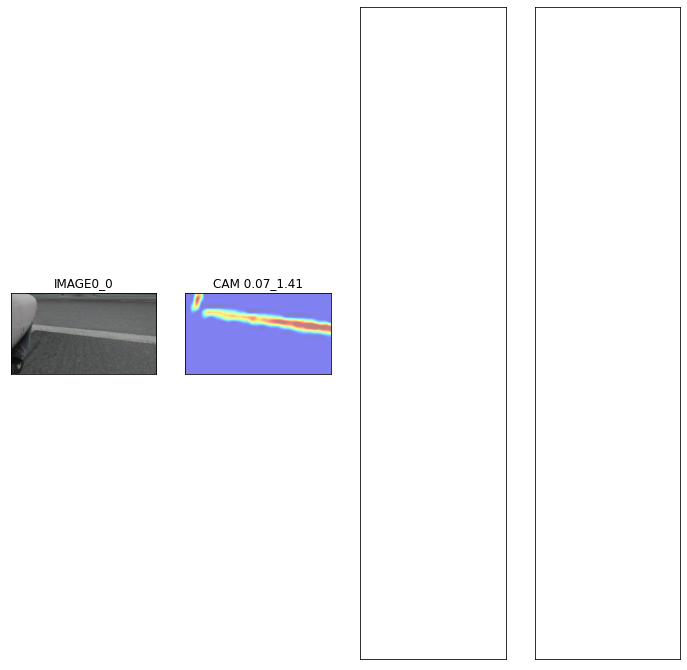

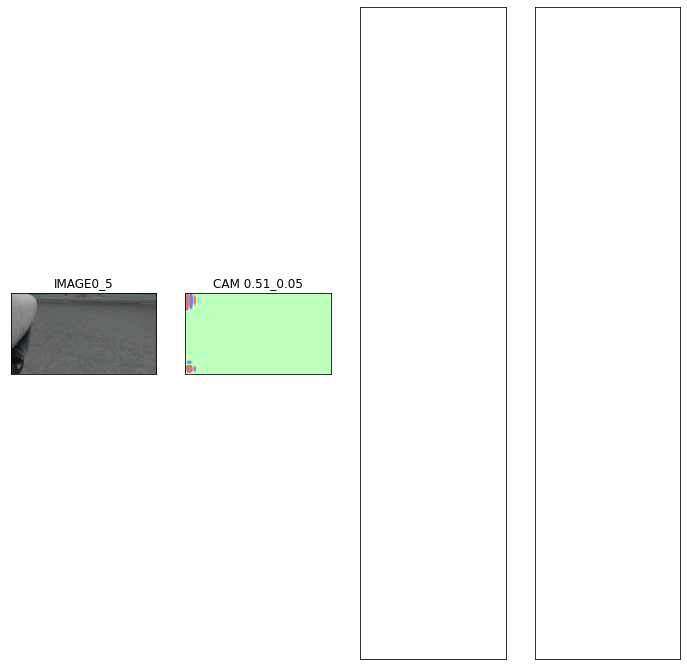

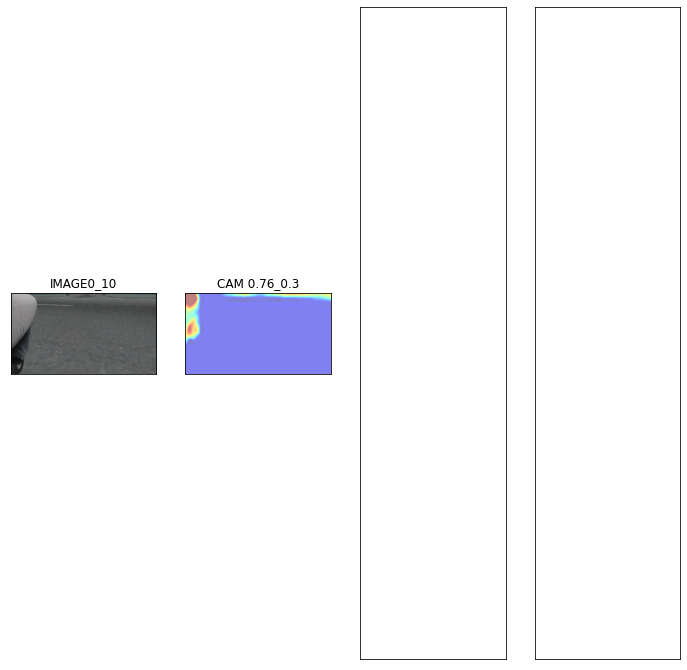

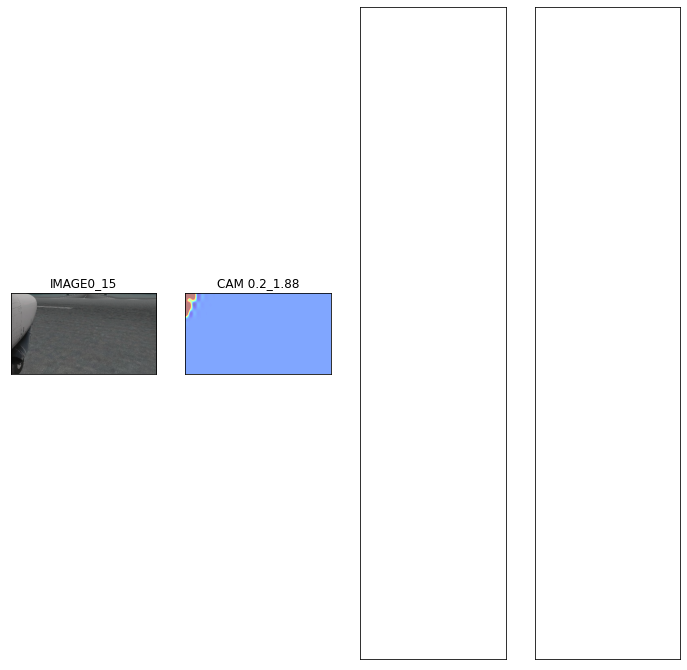

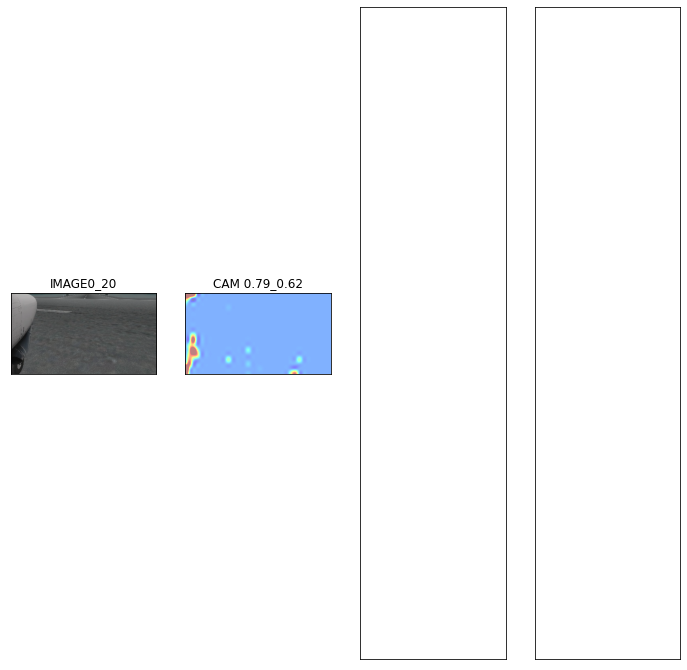

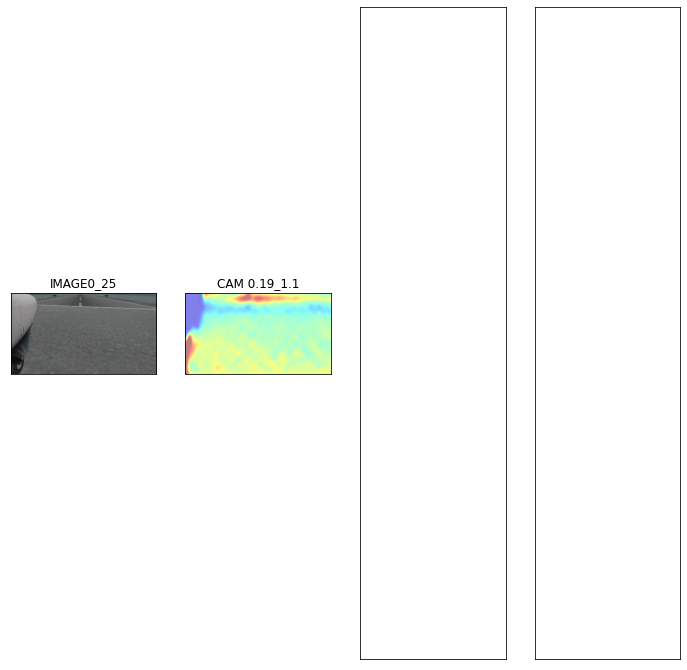

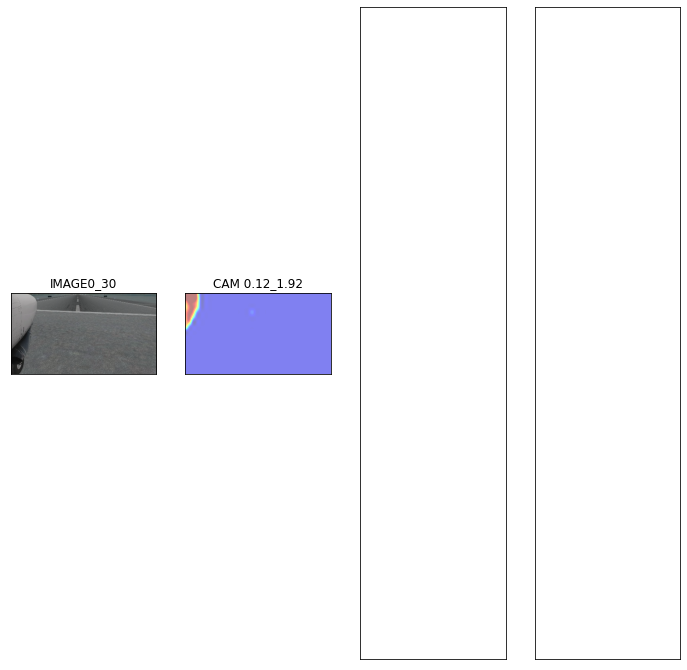

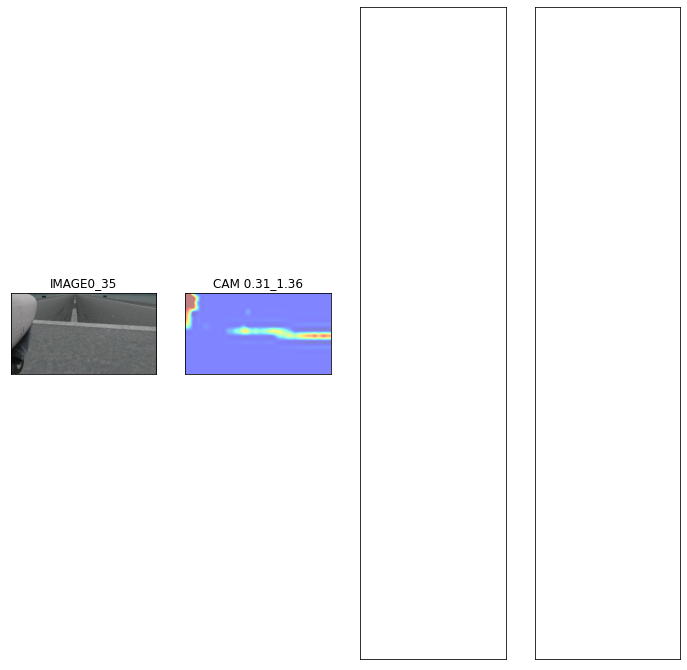

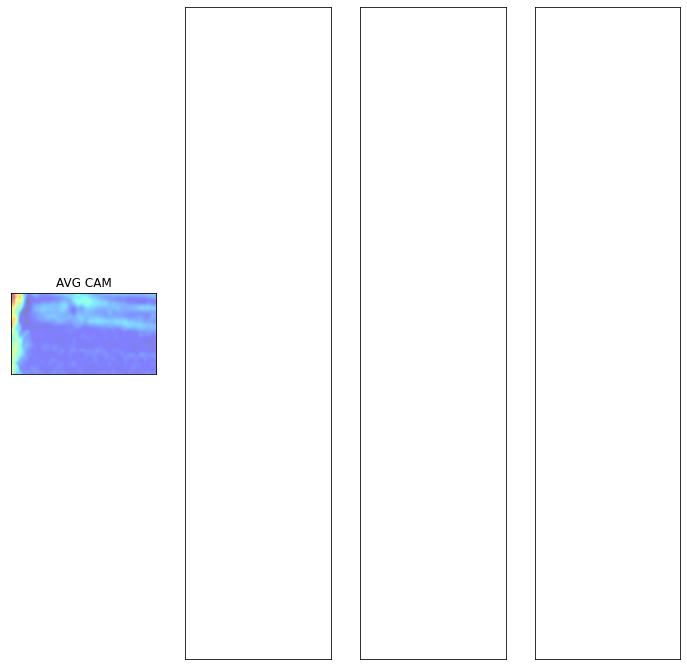

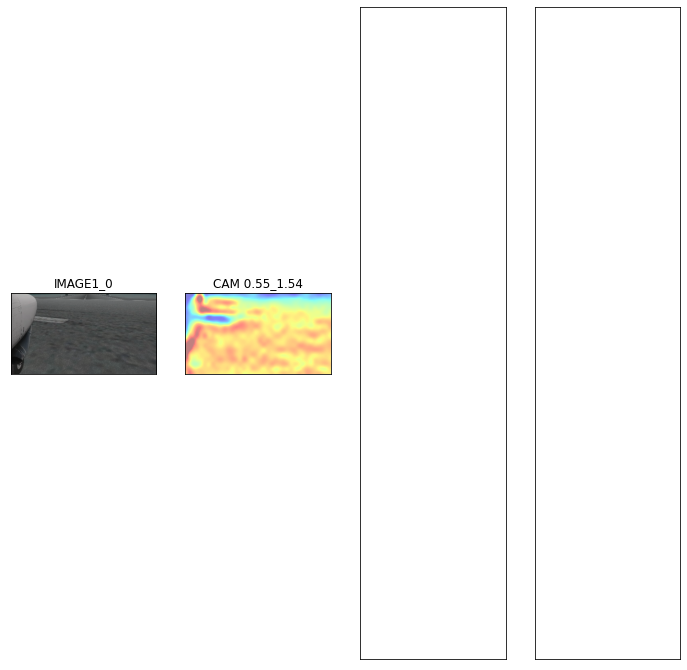

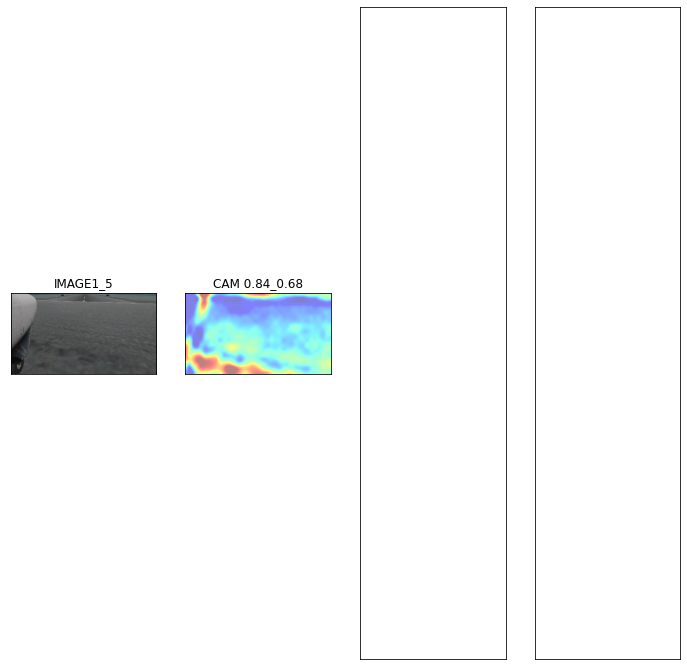

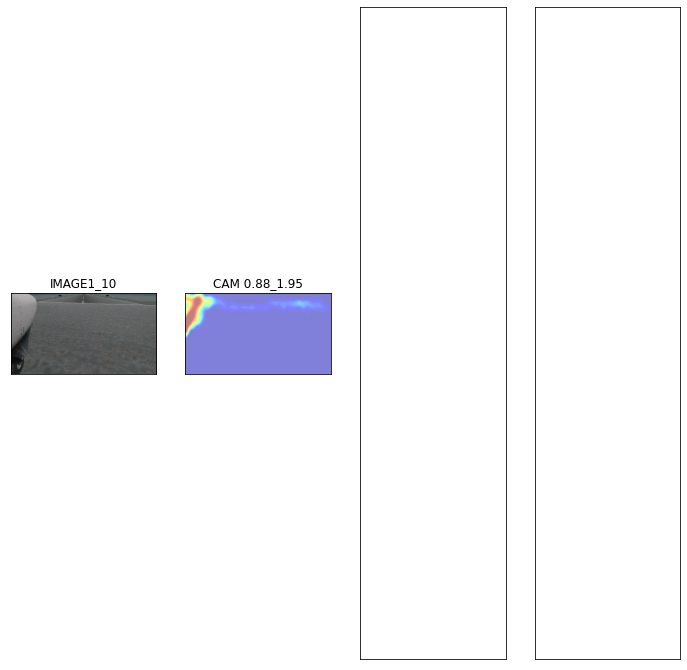

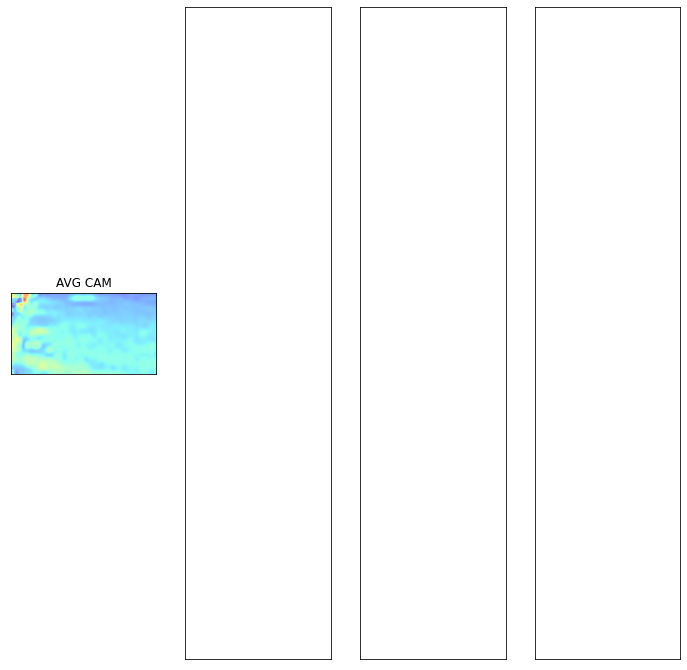

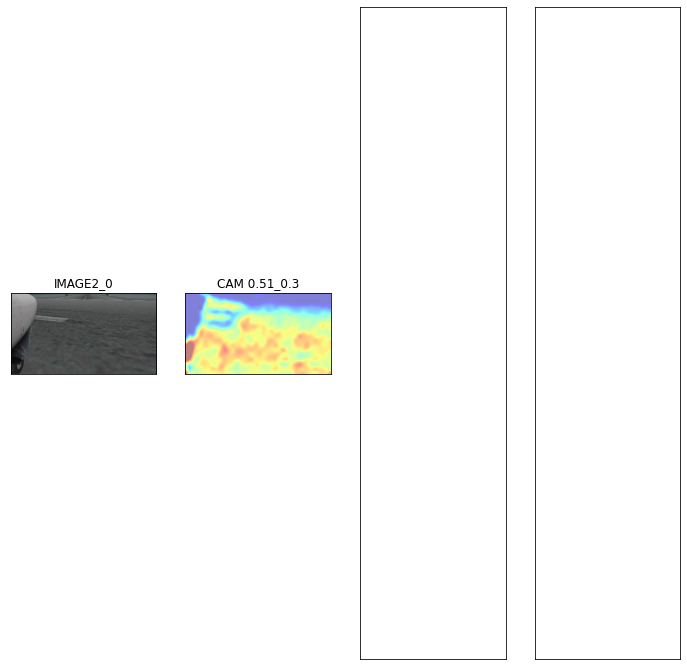

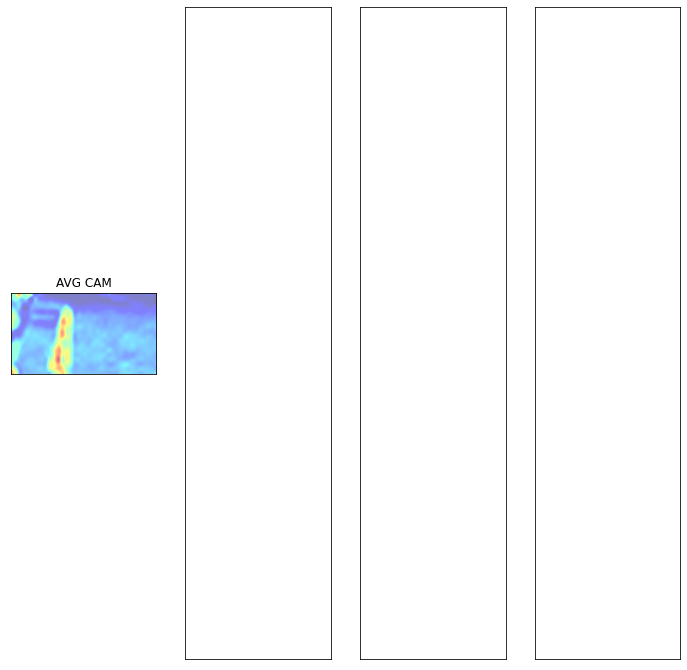

In [50]:
#invariants1 = get_all_invariants_vals(basic_estimator1)
#layer = 'dense_1'
#print("TEST DATA RULES FOR PROP ")
#describe_invariants_all_labels_vals(invariants1, None, layer, suffixes = test_suffixes1, label = test_predictions1)

invariants1F = get_all_invariants_vals(basic_estimator1F)
layer = 'dense_1'
print("TEST DATA RULES FOR FEATURE  ")
describe_invariants_all_labels_vals(invariants1F, None, layer, suffixes = test_suffixes1F, label = test_predictions1F)

#invariants1FT = get_all_invariants_vals(basic_estimator1FT)
#layer = 'dense_1'
#print("TEST DATA RULES FOR FEATURE AND PROP  ")
#describe_invariants_all_labels_vals(invariants1FT, None, layer, suffixes = test_suffixes1FT, label = test_predictions1FT)

#invariants1CI = get_all_invariants_vals(basic_estimator1CI)
#layer = 'dense_1'
#print("TEST DATA RULES FOR PROP ON SMALLER SET ")
#describe_invariants_all_labels_vals(invariants1CI, None, layer, suffixes = test_suffixes1CI, label = test_predictions1CI)

100%|██████████| 7/7 [00:00<00:00, 37689.51it/s]

Obtained all paths
TEST DATA RULES FOR FEATURE  

 PRINTING PURE RULES WITH SUPPORT MORE THAN 10:
Class:1, Rule:(neurons:[29, 46],signature:['>', -0.9605957269668579, '<=', 2.4051225185394287]), Support:44, Num misclassified0
IDEAL - ACT OPS: 0.37 0.02


IDEAL - ACT OPS: 0.19 1.06
IDEAL - ACT OPS: 0.65 0.98
IDEAL - ACT OPS: 0.07 1.51
IDEAL - ACT OPS: 0.93 0.29
IDEAL - ACT OPS: 0.49 1.43
IDEAL - ACT OPS: 0.79 1.92
IDEAL - ACT OPS: 0.19 1.1
IDEAL - ACT OPS: 0.12 1.92
Class:1, Rule:(neurons:[29, 14],signature:['<=', -0.9605957269668579, '>', -0.9979599416255951]), Support:6, Num misclassified0
IDEAL - ACT OPS: 0.07 1.41
IDEAL - ACT OPS: 0.03 2.09
Class:1, Rule:(neurons:[29, 14, 20, 39],signature:['<=', -0.9605957269668579, '<=', -0.9979599416255951, '>', -0.4891539216041565, '>', 2.913216710090637]), Support:3, Num misclassified0
IDEAL - ACT OPS: 0.2 0.49
Class:1, Rule:(neurons:[29, 14, 20, 12],signature:['<=', -0.9605957269668579, '<=', -0.9979599416255951, '<=', -0.4891539216041565, '<=', -0.9965606331825256]), Support:1, Num misclassified0
IDEAL - ACT OPS: 0.51 0.3
Class:0, Rule:(neurons:[29, 14, 20, 12],signature:['<=', -0.9605957269668579, '<=', -0.9979599416255951, '<=', -0.4891539216041565, '>', -0.9965606331825256]), Support:189, 

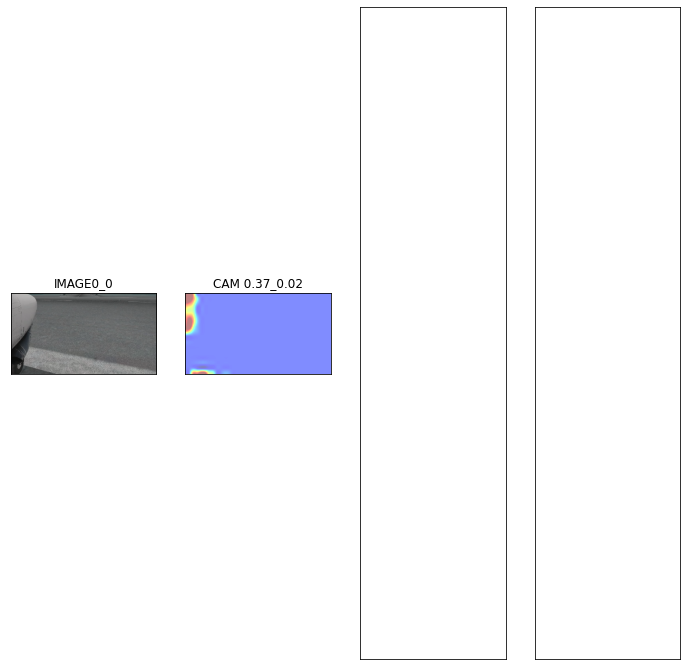

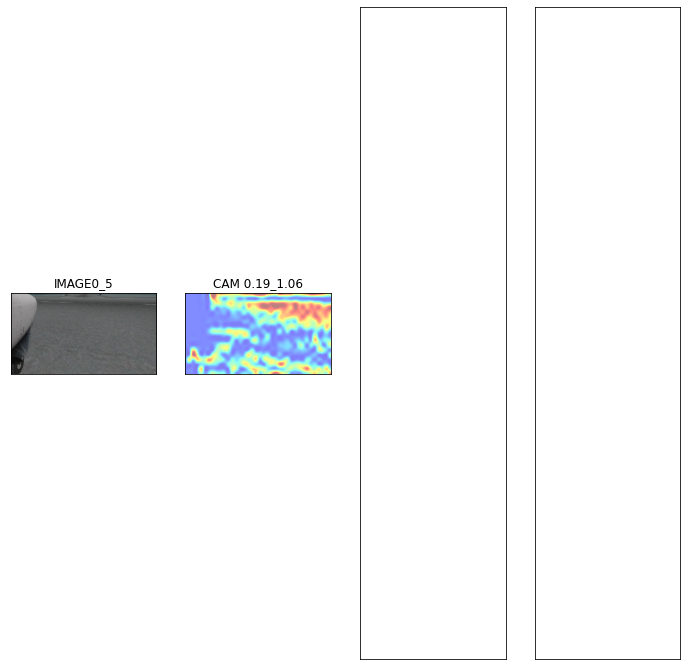

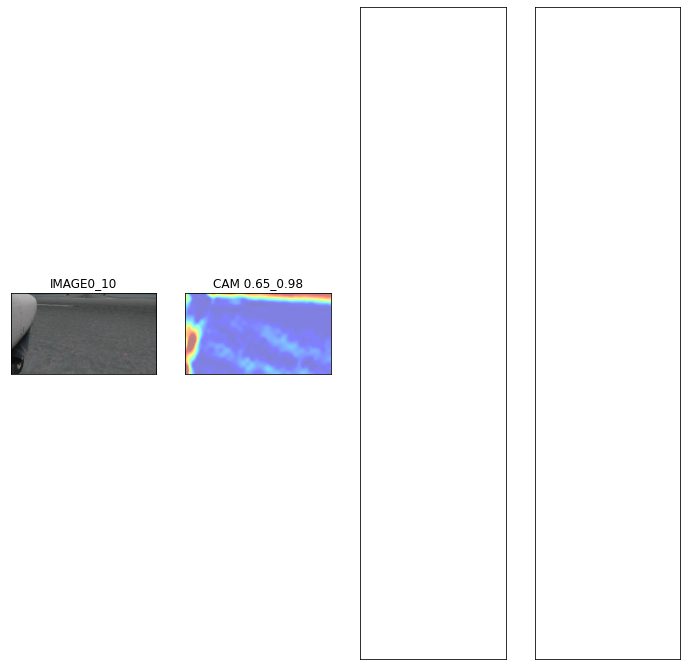

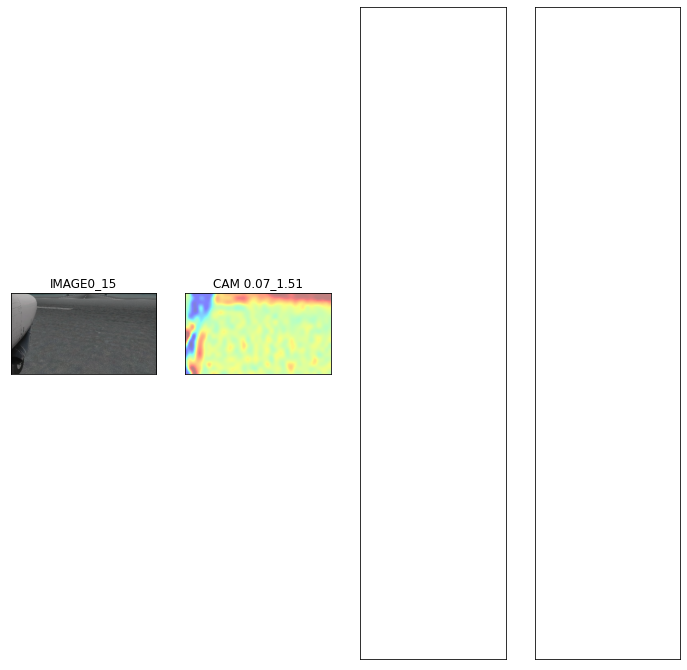

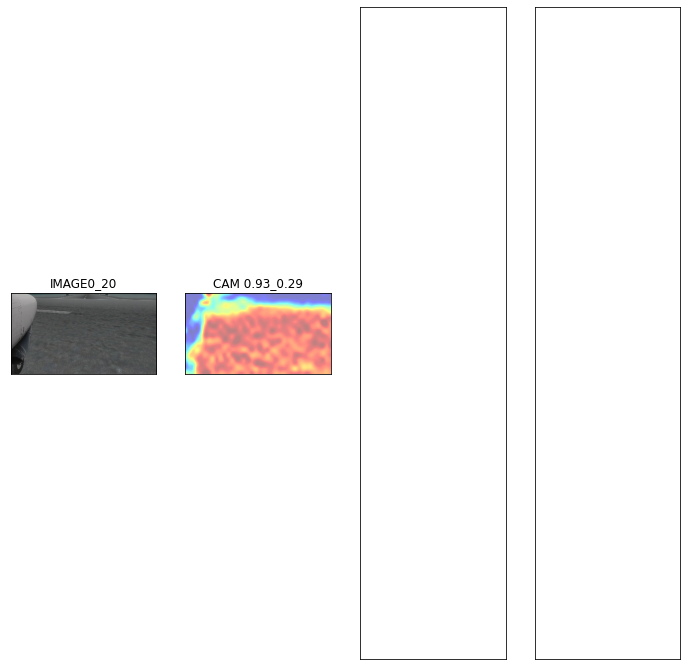

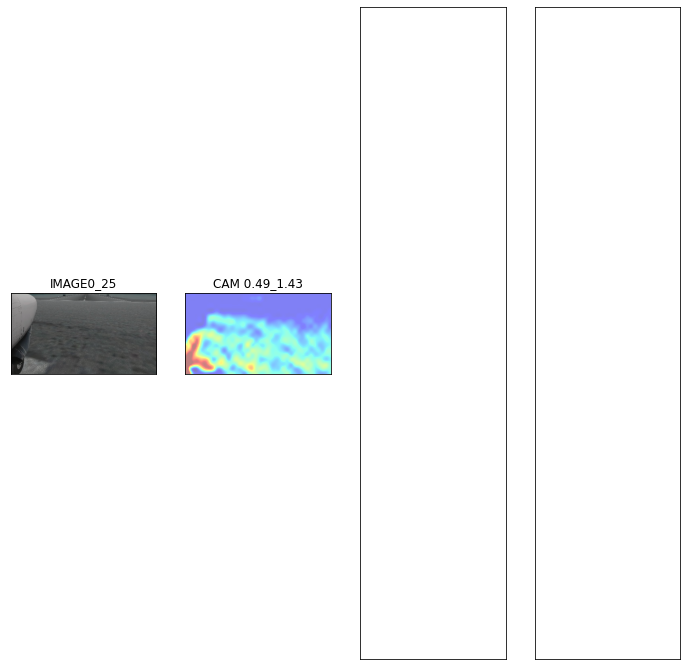

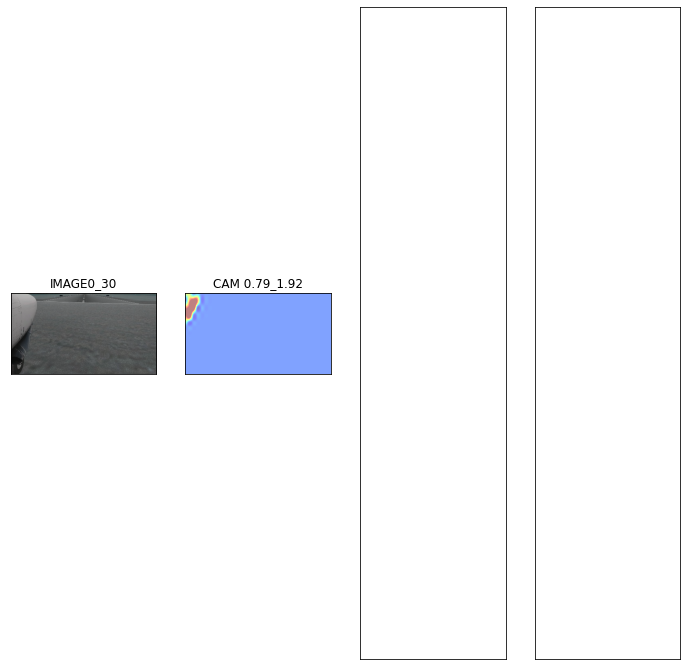

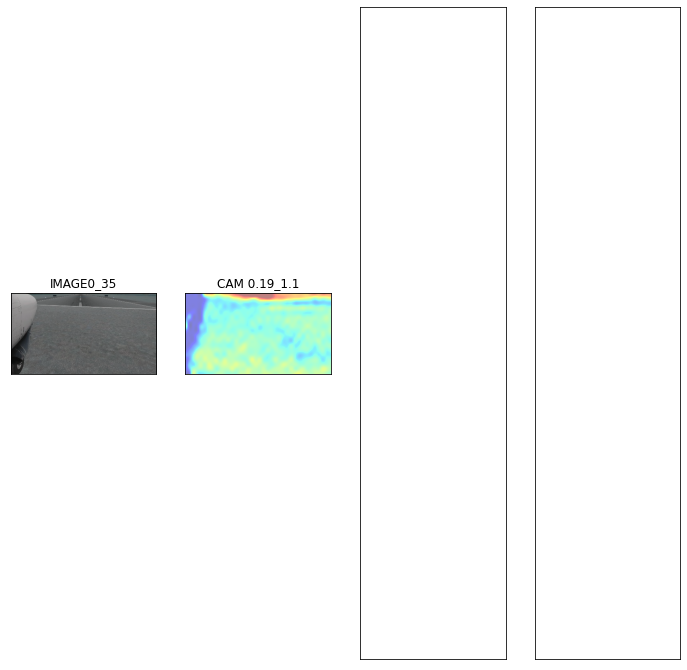

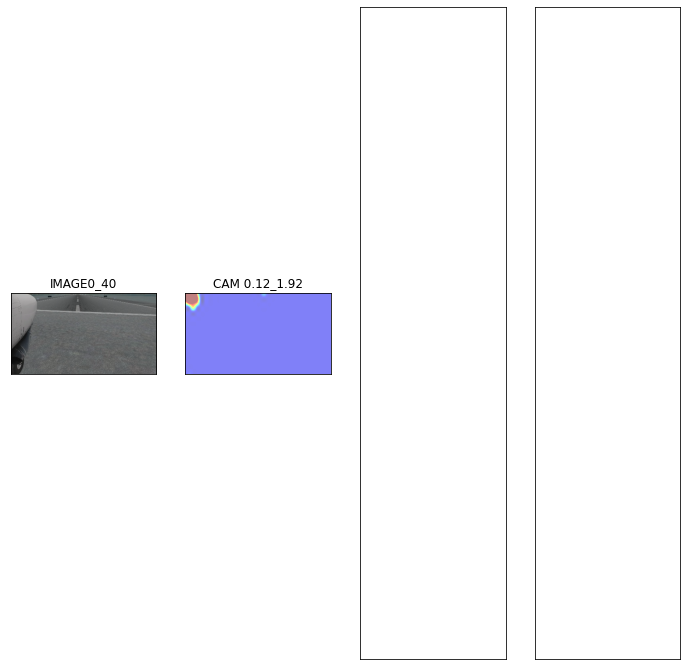

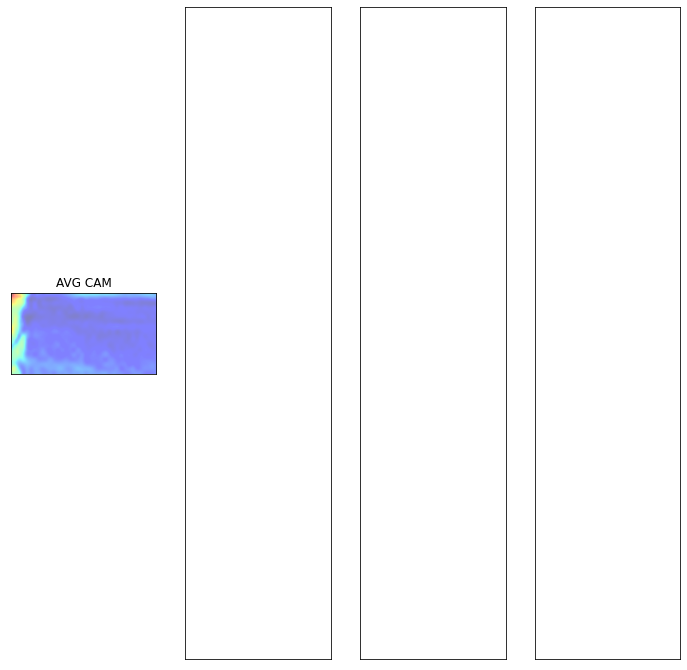

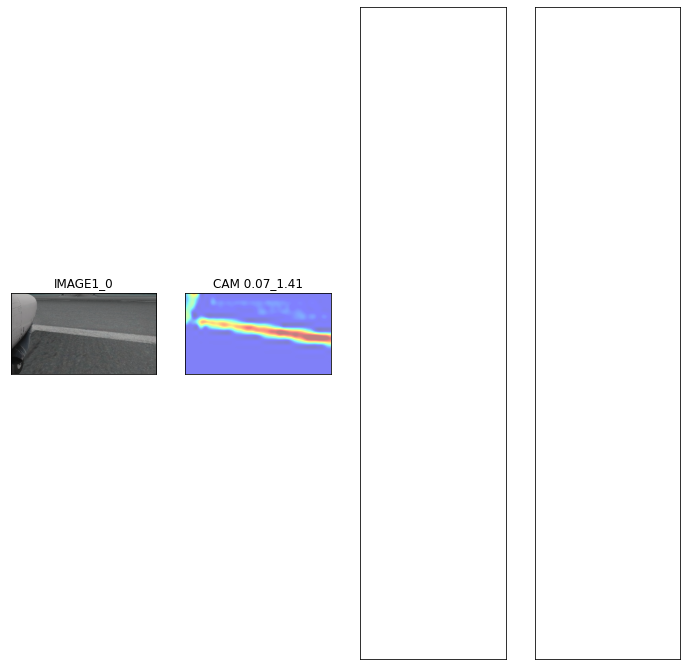

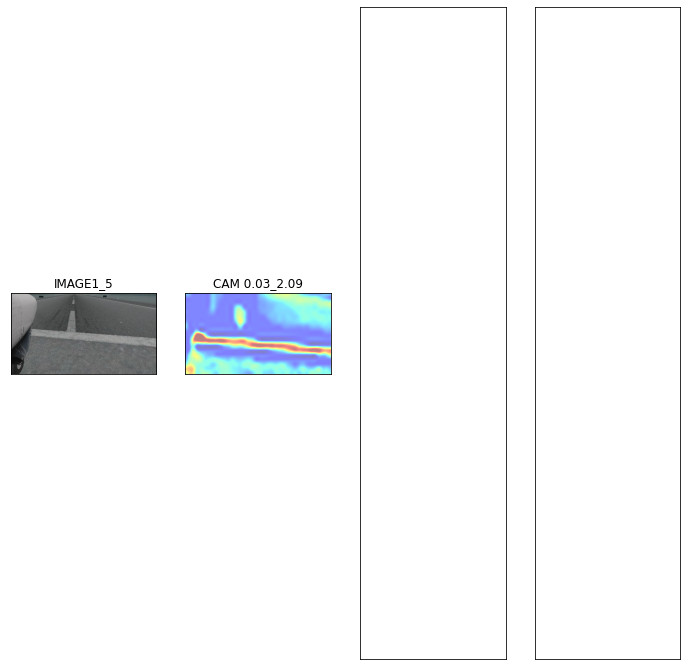

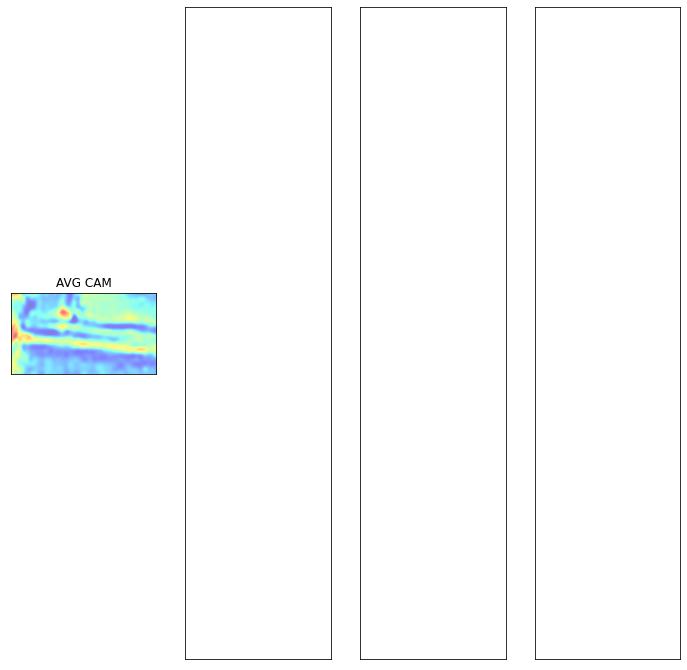

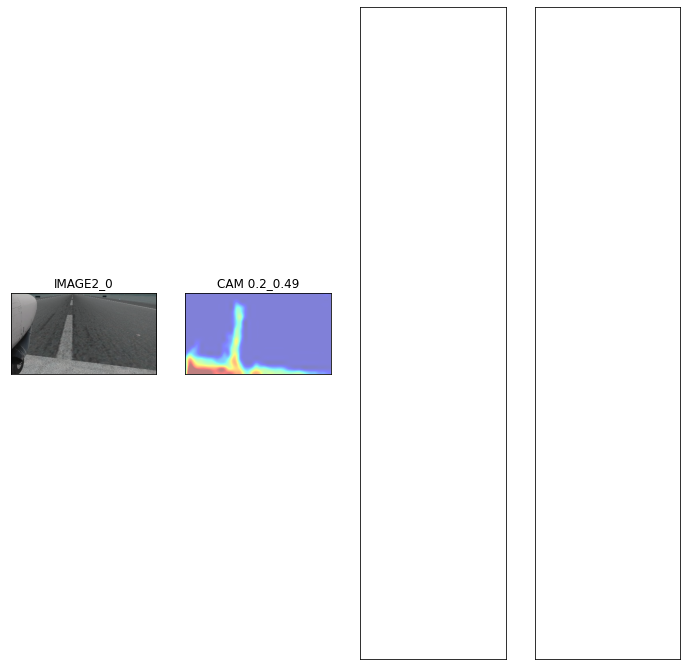

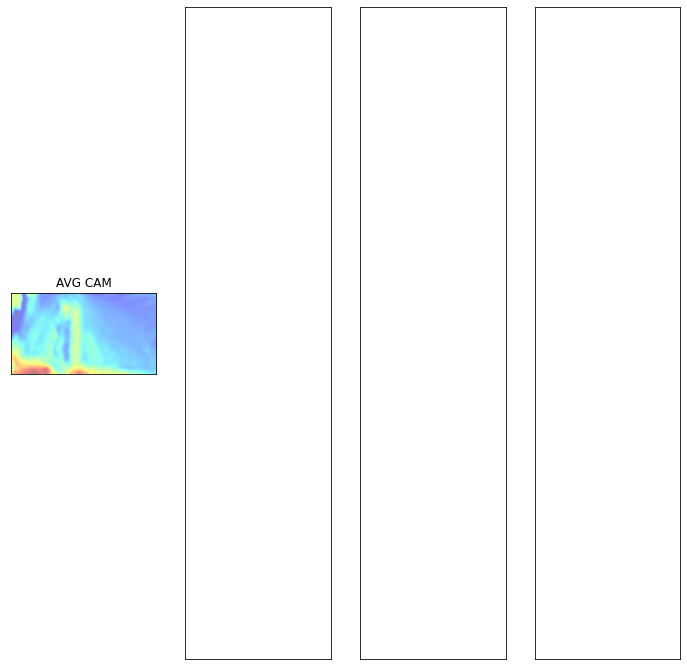

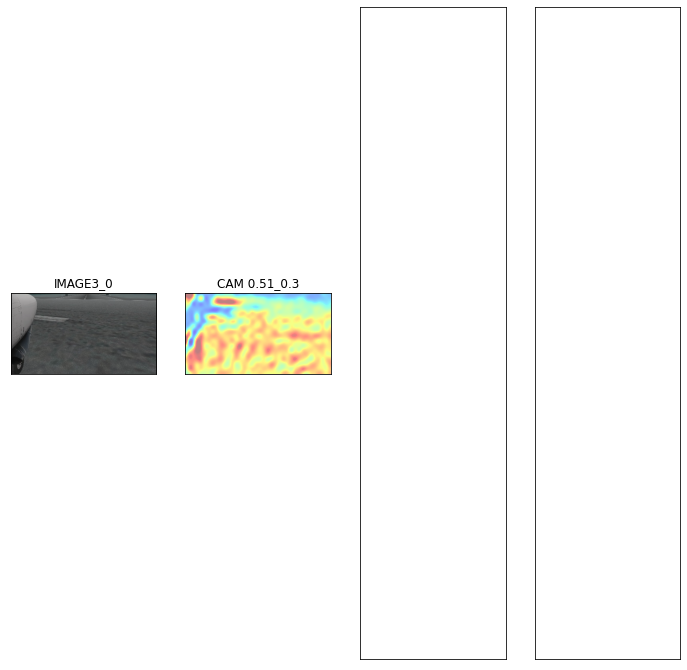

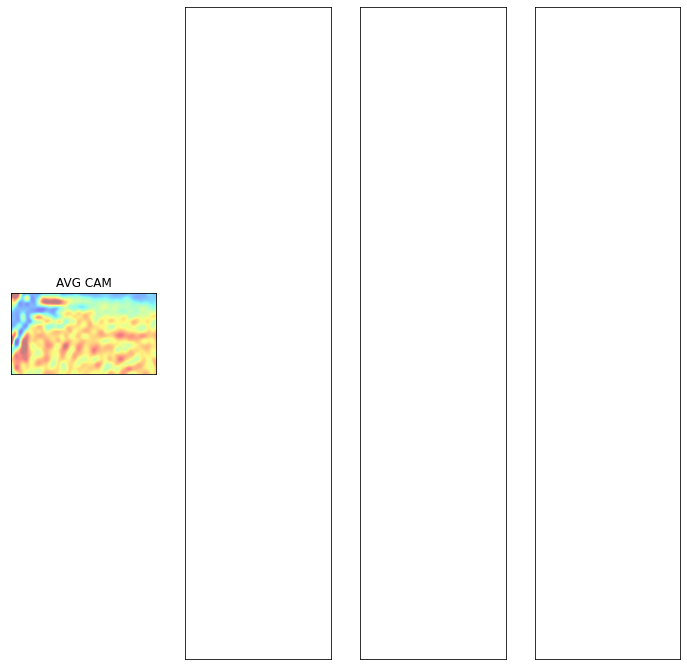

In [51]:
#invariants2 = get_all_invariants_vals(basic_estimator2)
#layer = 'dense_2'
#print("TEST DATA RULES FOR PROP ")
#describe_invariants_all_labels_vals(invariants2, None, layer, suffixes = test_suffixes2, label = test_predictions2)

invariants2F = get_all_invariants_vals(basic_estimator2F)
layer = 'dense_2'
print("TEST DATA RULES FOR FEATURE  ")
describe_invariants_all_labels_vals(invariants2F, None, layer, suffixes = test_suffixes2F, label = test_predictions2F)

#invariants2FT = get_all_invariants_vals(basic_estimator2FT)
#layer = 'dense_2'
#print("TEST DATA RULES FOR FEATURE AND PROP  ")
#describe_invariants_all_labels_vals(invariants2FT, None, layer, suffixes = test_suffixes2FT, label = test_predictions2FT)

#invariants2CI = get_all_invariants_vals(basic_estimator2CI)
#layer = 'dense_2'
#print("TEST DATA RULES FOR PROP ON SMALLER SET ")
#describe_invariants_all_labels_vals(invariants2CI, None, layer, suffixes = test_suffixes2CI, label = test_predictions2CI)

100%|██████████| 17/17 [00:00<00:00, 45329.41it/s]

Obtained all paths
TEST DATA RULES FOR FEATURE  

 PRINTING PURE RULES WITH SUPPORT MORE THAN 10:
Class:1, Rule:(neurons:[7],signature:['<=', -0.967147946357727]), Support:26, Num misclassified0
IDEAL - ACT OPS: 0.37 0.02


IDEAL - ACT OPS: 0.19 1.06
IDEAL - ACT OPS: 0.65 0.98
IDEAL - ACT OPS: 0.25 1.37
IDEAL - ACT OPS: 0.07 1.82
IDEAL - ACT OPS: 0.03 2.09
Class:1, Rule:(neurons:[7, 3, 4, 6, 3],signature:['>', -0.967147946357727, '<=', 1.6005209684371948, '<=', -0.9288498163223267, '>', 0.23447272926568985, '<=', 1.5894967317581177]), Support:17, Num misclassified0
IDEAL - ACT OPS: 0.13 1.48
IDEAL - ACT OPS: 0.73 0.07
IDEAL - ACT OPS: 1.02 0.83
IDEAL - ACT OPS: 0.77 1.64
Class:1, Rule:(neurons:[7, 3, 8, 1, 6, 1, 4],signature:['>', -0.967147946357727, '>', 1.6005209684371948, '<=', -0.9297838807106018, '<=', -0.8250273764133453, '>', -0.6920352280139923, '>', -0.9704877138137817, '<=', -0.957706868648529]), Support:3, Num misclassified0
IDEAL - ACT OPS: 0.2 0.49
Class:1, Rule:(neurons:[7, 3, 4, 6, 3, 2],signature:['>', -0.967147946357727, '<=', 1.6005209684371948, '<=', -0.9288498163223267, '>', 0.23447272926568985, '>', 1.5894967317581177, '<=', -0.8103539943695068]), Support:2, Num misclassified0
IDEAL -

<ipython-input-48-5d2e459fd54d>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f1, ax1 = plt.subplots(**subplot_args)
<ipython-input-48-5d2e459fd54d>:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f2, ax2 = plt.subplots(**subplot_args)


Class:1, Rule:(neurons:[7, 3, 8, 1, 6, 1, 4, 8, 7, 7],signature:['>', -0.967147946357727, '>', 1.6005209684371948, '<=', -0.9297838807106018, '<=', -0.8250273764133453, '>', -0.6920352280139923, '>', -0.9704877138137817, '>', -0.957706868648529, '>', -0.9728510081768036, '<=', -0.9639780223369598, '>', -0.9650127291679382]), Support:1, Num misclassified0
IDEAL - ACT OPS: 0.31 1.4
Class:1, Rule:(neurons:[7, 3, 8, 1],signature:['>', -0.967147946357727, '>', 1.6005209684371948, '<=', -0.9297838807106018, '>', -0.8250273764133453]), Support:1, Num misclassified0
IDEAL - ACT OPS: 0.2 1.88
Class:1, Rule:(neurons:[7, 3, 8],signature:['>', -0.967147946357727, '>', 1.6005209684371948, '>', -0.9297838807106018]), Support:1, Num misclassified0
IDEAL - ACT OPS: 0.52 2.6
Class:0, Rule:(neurons:[7, 3, 8, 1, 6, 1],signature:['>', -0.967147946357727, '>', 1.6005209684371948, '<=', -0.9297838807106018, '<=', -0.8250273764133453, '>', -0.6920352280139923, '<=', -0.9704877138137817]), Support:115, Num mi

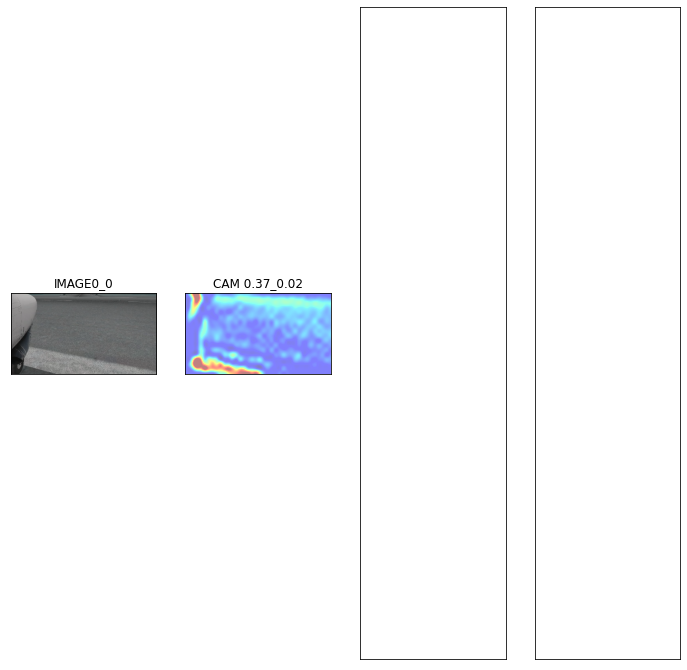

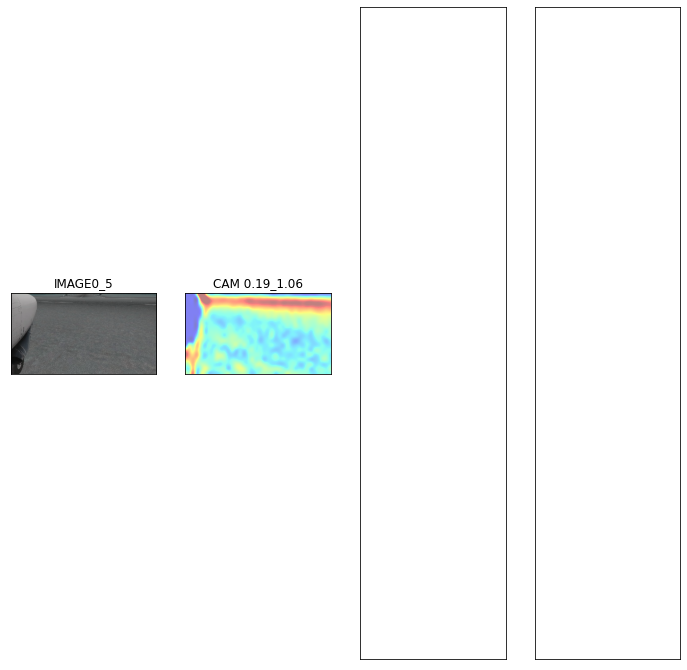

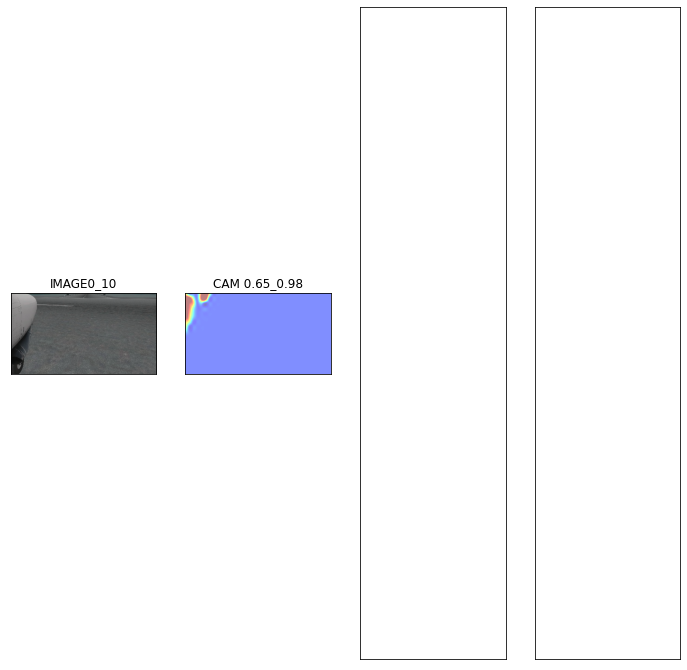

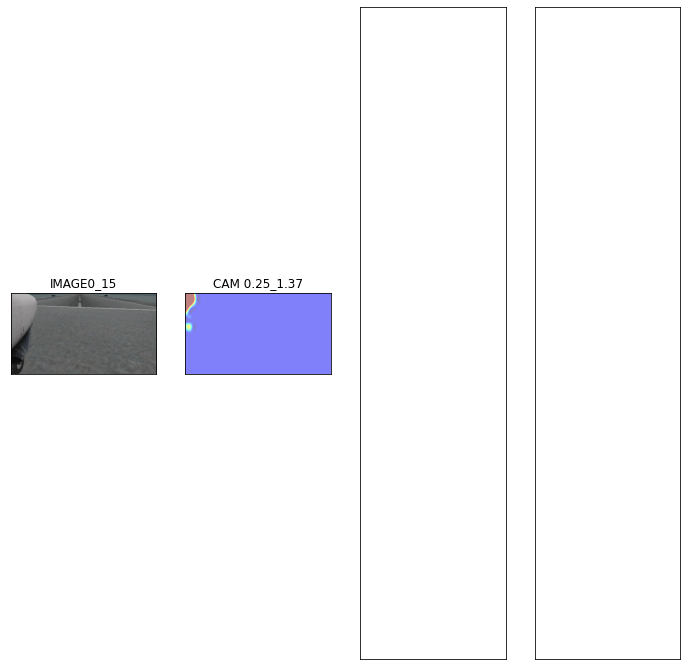

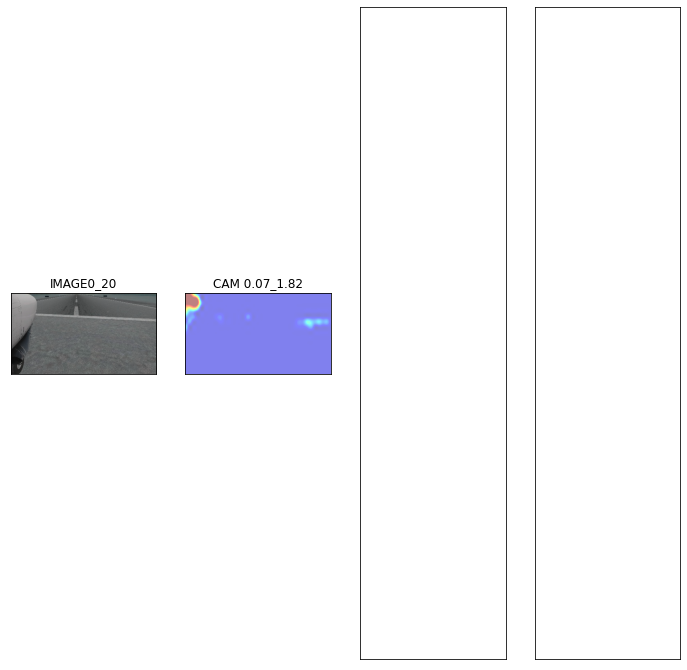

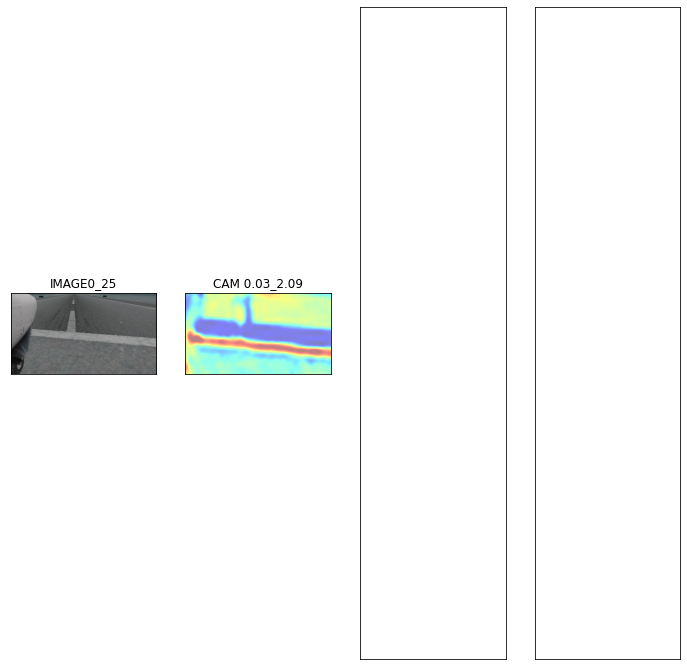

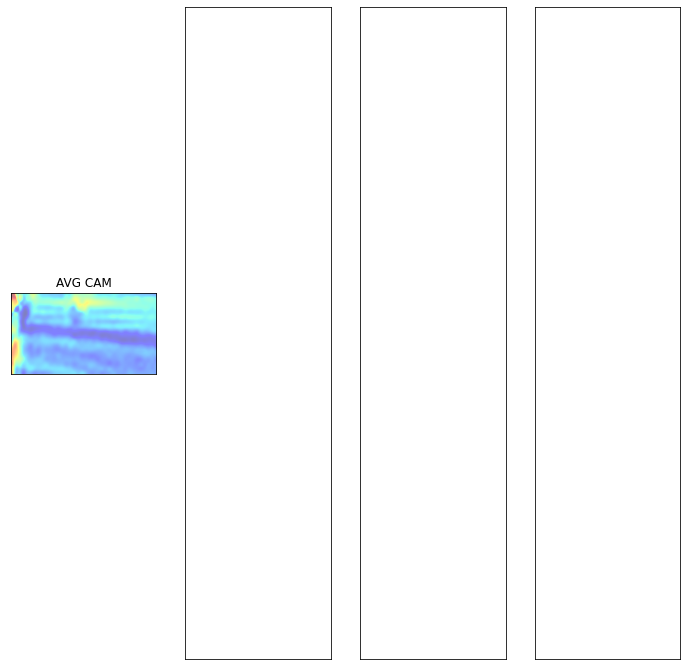

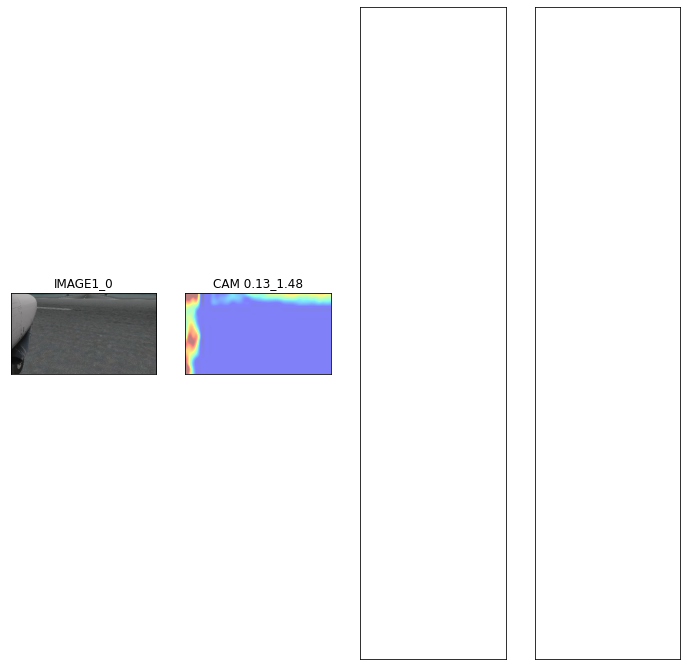

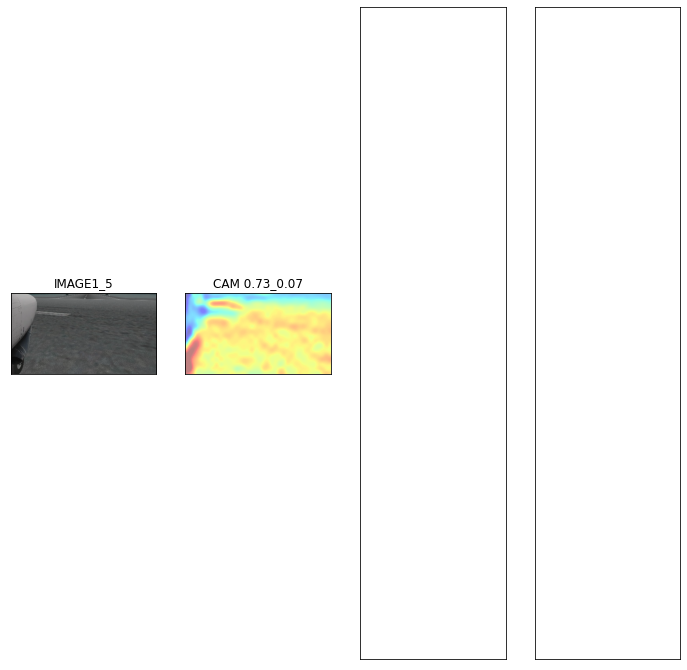

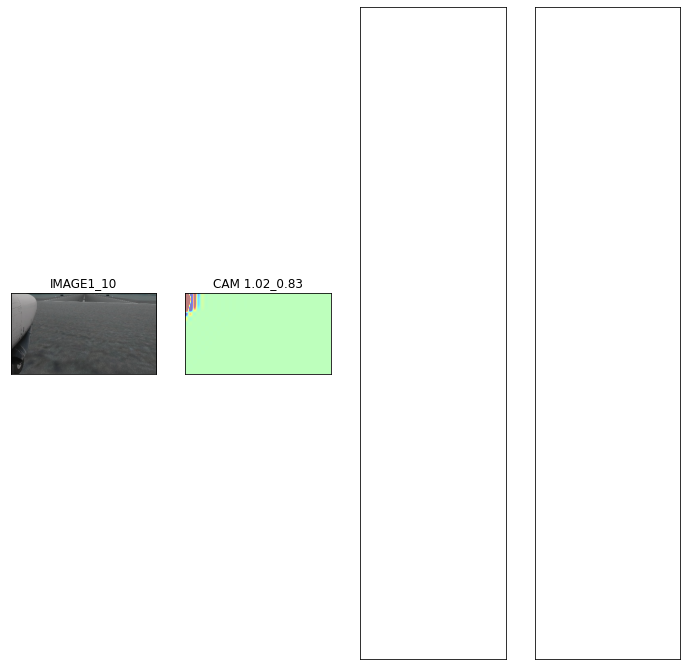

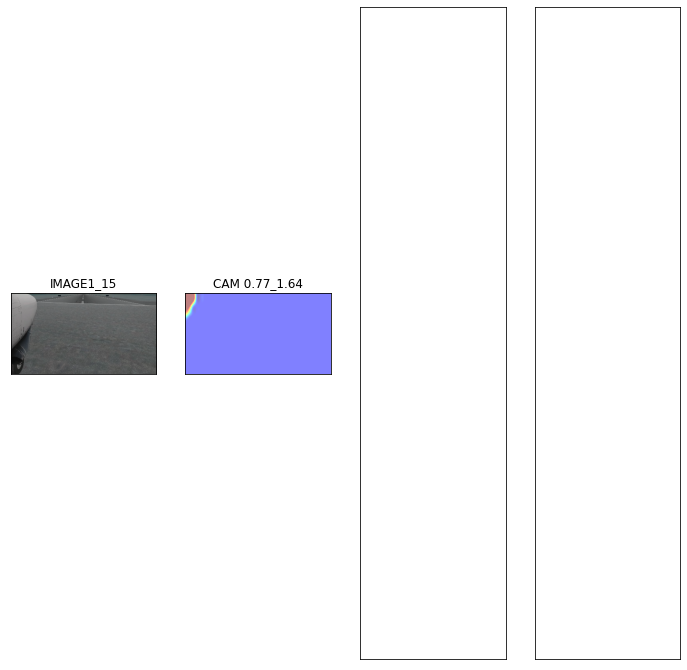

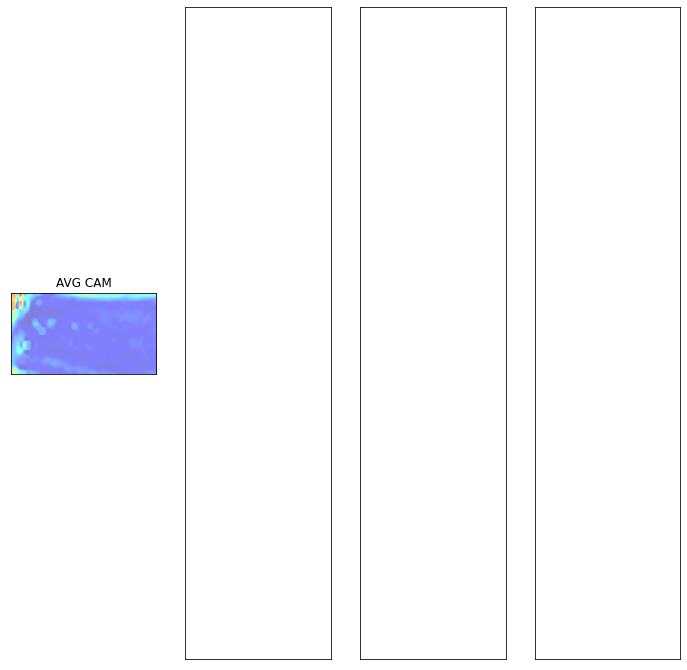

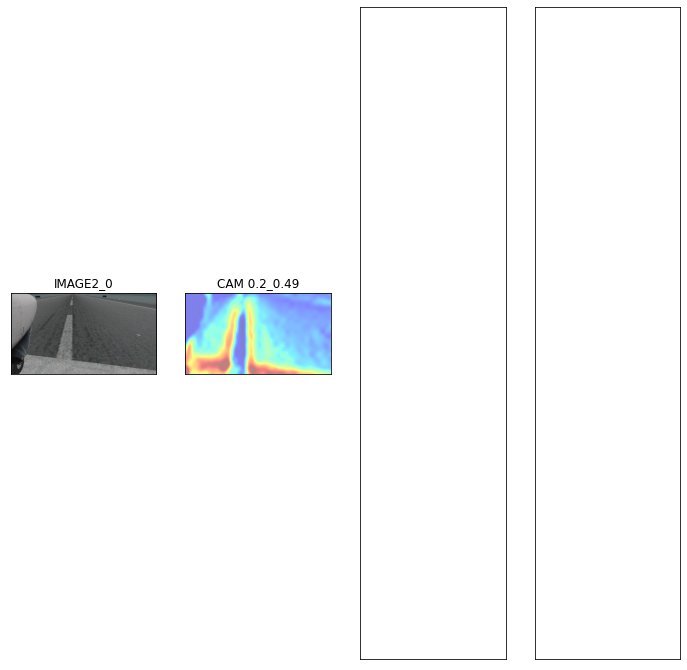

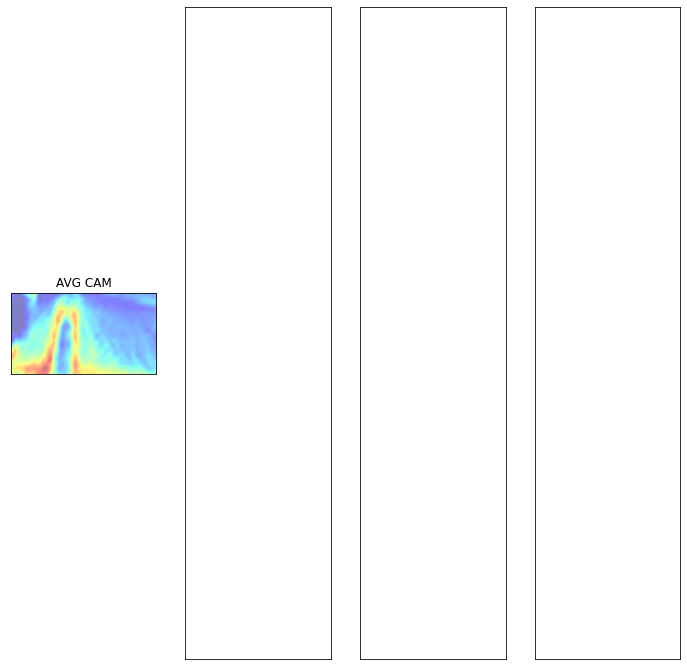

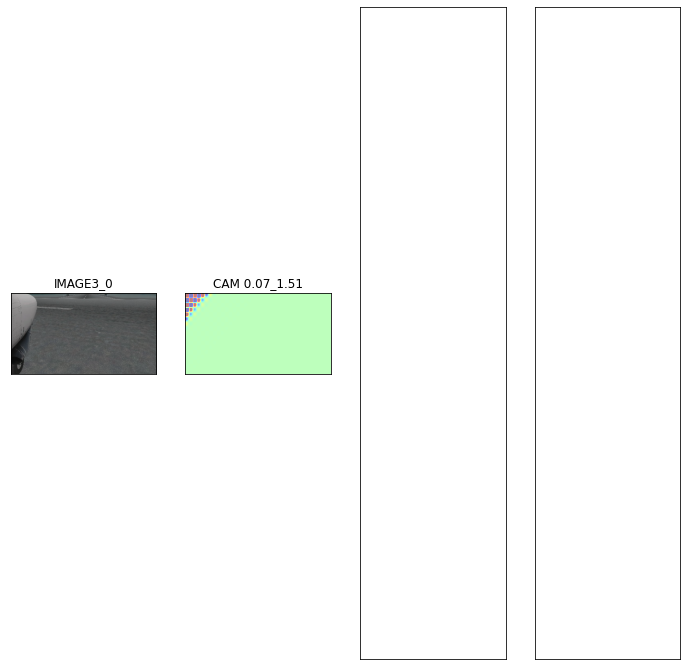

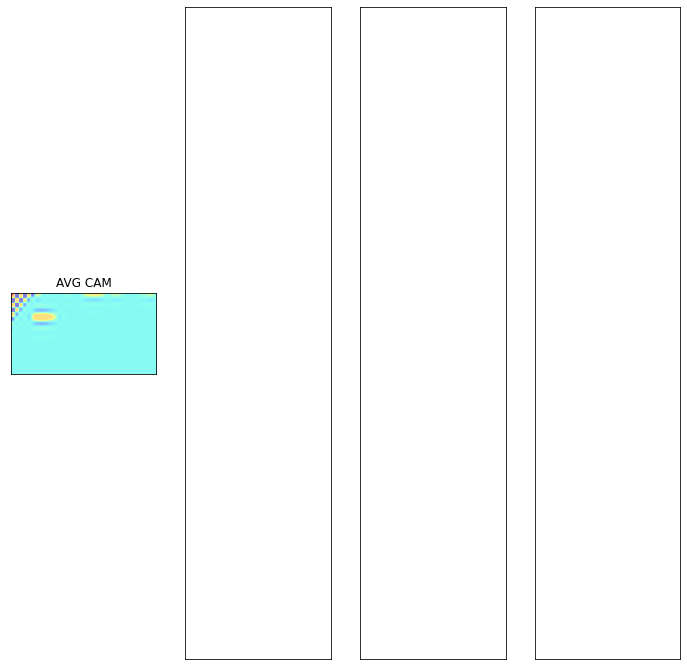

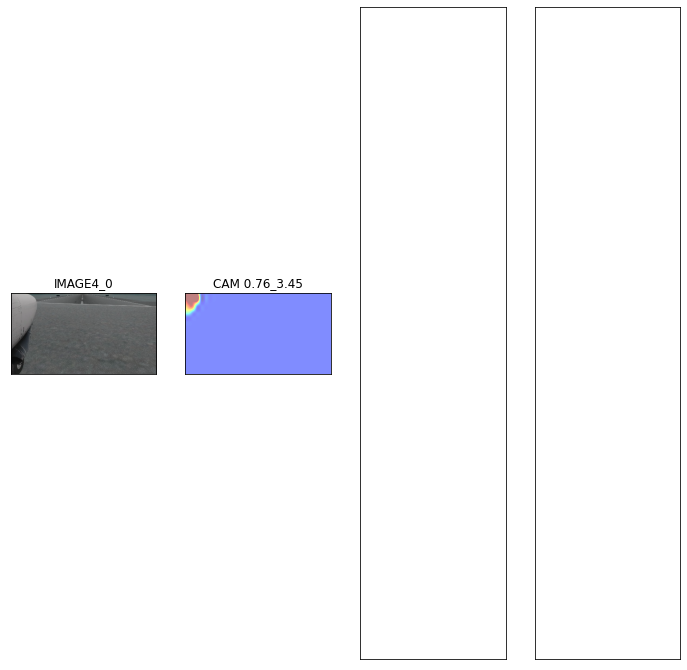

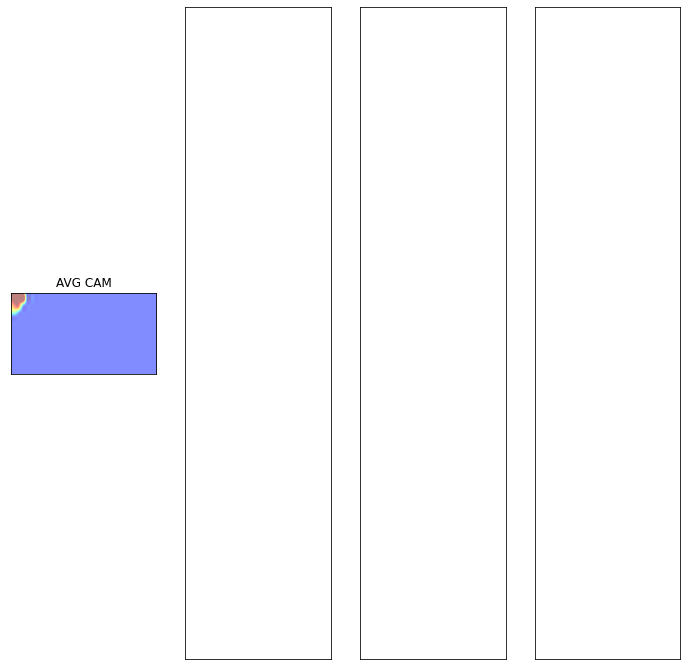

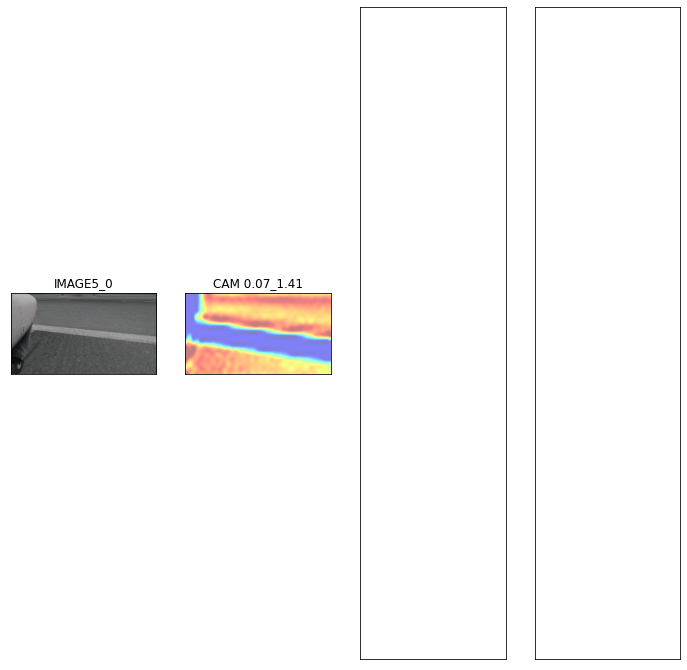

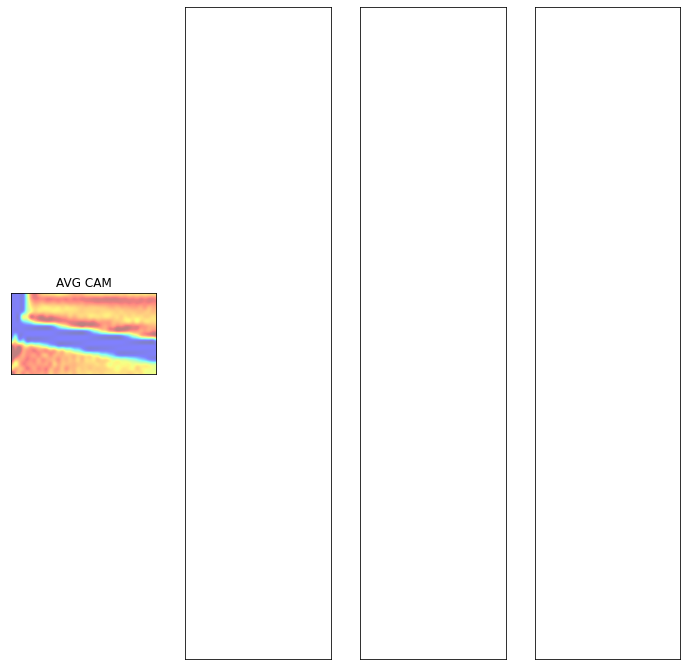

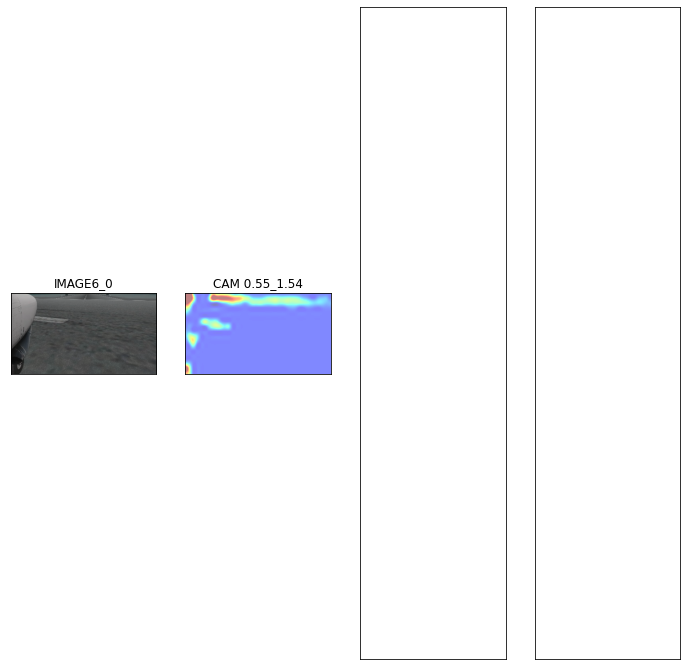

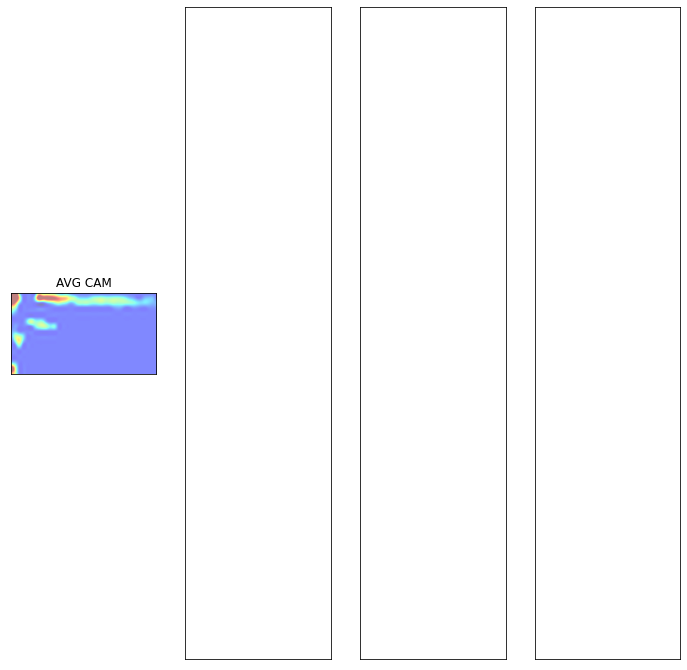

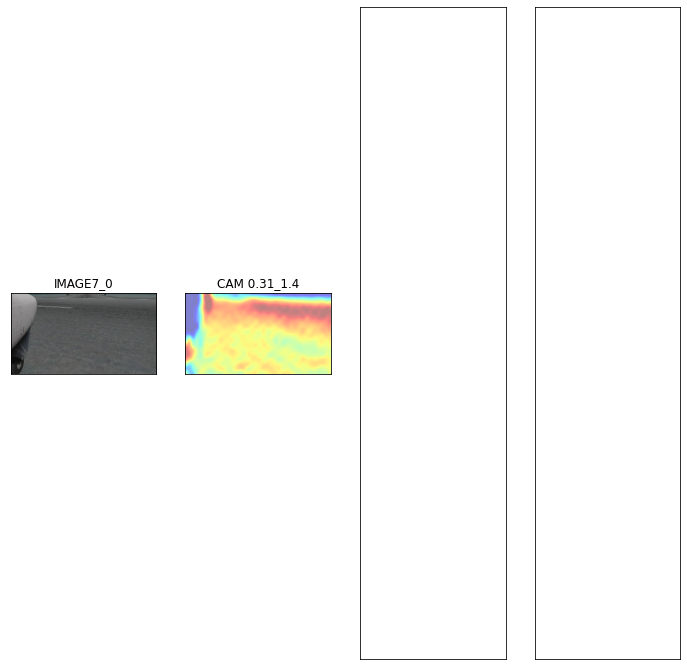

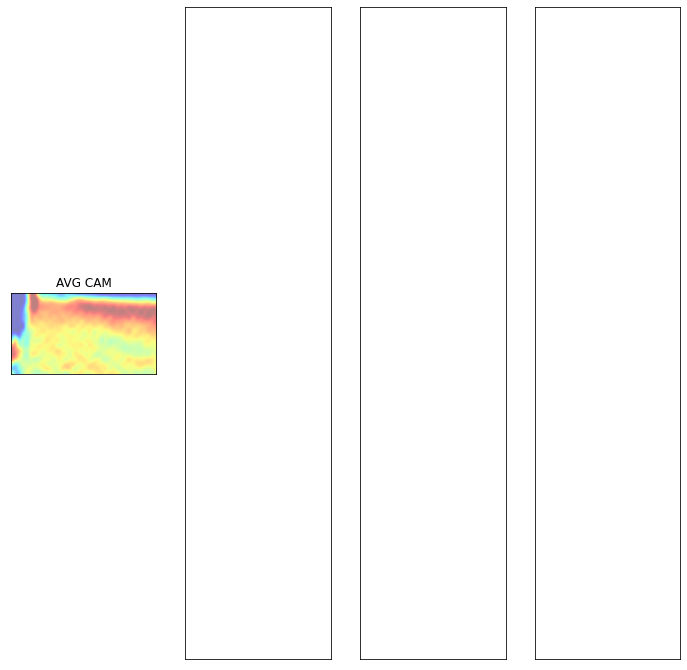

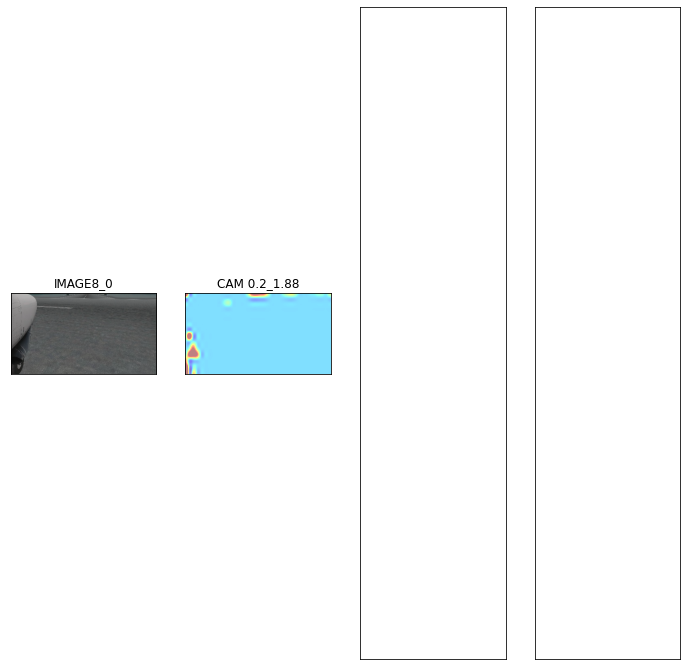

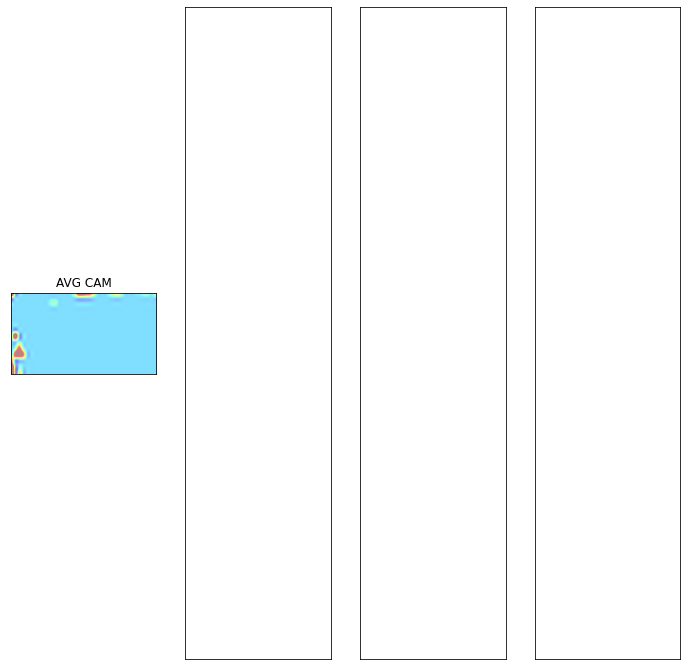

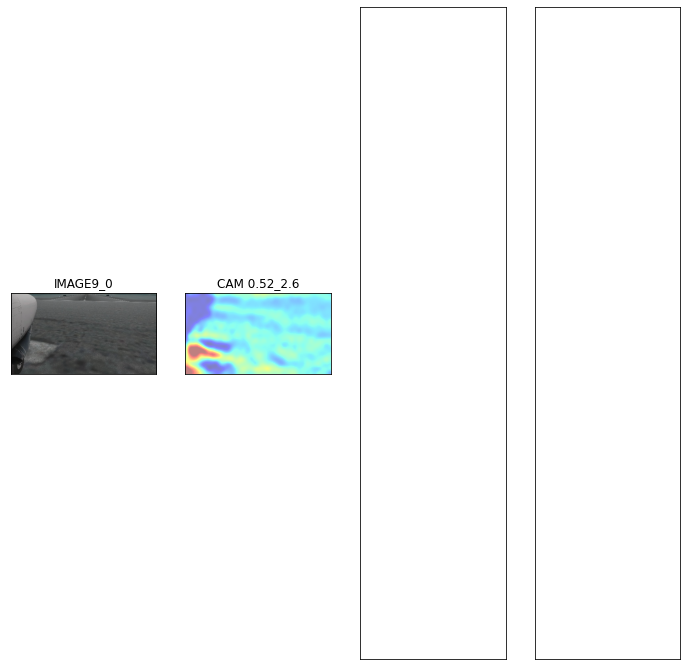

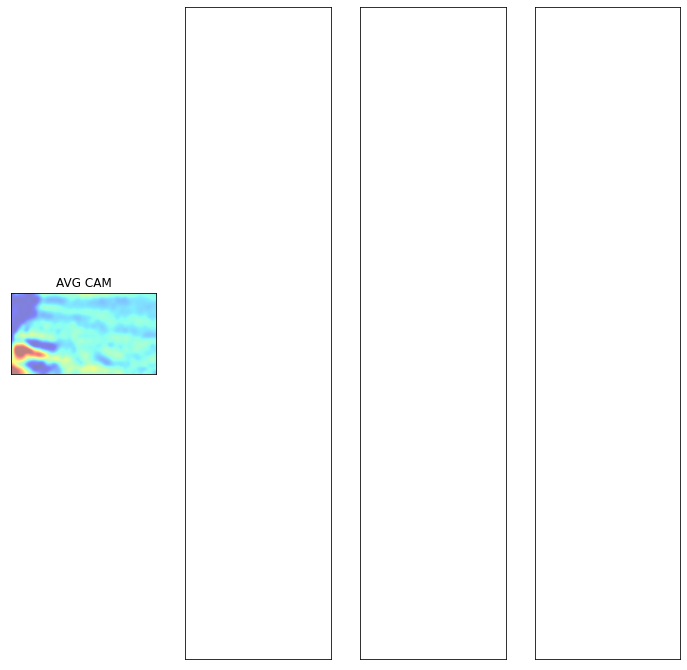

In [52]:
#invariants3 = get_all_invariants_vals(basic_estimator3)
#layer = 'dense_3'
#print("TEST DATA RULES FOR PROP ")
#describe_invariants_all_labels_vals(invariants3, None, layer, suffixes = test_suffixes3, label = test_predictions3)

invariants3F = get_all_invariants_vals(basic_estimator3F)
layer = 'dense_3'
print("TEST DATA RULES FOR FEATURE  ")
describe_invariants_all_labels_vals(invariants3F, None, layer, suffixes = test_suffixes3F, label = test_predictions3F)

#invariants3FT = get_all_invariants_vals(basic_estimator3FT)
#layer = 'dense_3'
#print("TEST DATA RULES FOR FEATURE AND PROP  ")
#describe_invariants_all_labels_vals(invariants3FT, None, layer, suffixes = test_suffixes3FT, label = test_predictions3FT)

#invariants3CI = get_all_invariants_vals(basic_estimator3CI)
#layer = 'dense_3'
#print("TEST DATA RULES FOR PROP ON SMALLER SET ")
#describe_invariants_all_labels_vals(invariants3CI, None, layer, suffixes = test_suffixes3CI, label = test_predictions3CI)

In [ ]:
invariantsA = get_all_invariants_vals(basic_estimatorA)
layer = 'ALL'
print("TEST DATA RULES FOR PROP ")
describe_invariants_all_labels_vals(invariantsA, None, layer, suffixes = test_suffixesA, label = test_predictionsA)

invariantsAF = get_all_invariants_vals(basic_estimatorAF)
layer = 'ALL'
print("TEST DATA RULES FOR FEATURE  ")
describe_invariants_all_labels_vals(invariantsAF, None, layer, suffixes = test_suffixesAF, label = test_predictionsAF)

invariantsAFT = get_all_invariants_vals(basic_estimatorAFT)
layer = 'ALL'
print("TEST DATA RULES FOR FEATURE AND PROP  ")
describe_invariants_all_labels_vals(invariantsAFT, None, layer, suffixes = test_suffixesAFT, label = test_predictionsAFT)

invariantsACI = get_all_invariants_vals(basic_estimatorACI)
layer = 'ALL'
print("TEST DATA RULES FOR PROP ON SMALLER SET ")
describe_invariants_all_labels_vals(invariantsACI, None, layer, suffixes = test_suffixesACI, label = test_predictionsACI)

In [ ]:
def check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL = True,ALL=False):
   
   if (VAL == False):
     if ((suff[:,neuron_ids][0] == neuron_sig).all(axis=0)):
        return True
     else:
        return False

   
   found = True
   oper = -1
   layer_vals = (layer_vals).flatten()
   
   for ix in range(0,len(neuron_ids)):
     found = True
     for ind in range(0,len(neuron_ids[ix])):
       if (ind % 2 == 0):
         op = neuron_sig[ix][ind]
         if (op == '<='):
           oper = 0
         else:
           oper = 1
       else:
         v = neuron_ids[ix][ind]
         vsig = neuron_sig[ix][ind]
         val = layer_vals[v]
         #print(oper, v, vsig, val)
         if (oper == 0):
           if (val > vsig):
             found = False
             break
         else:
           if (val <= vsig):
            found = False
            break
         oper = -1
     if (found == True):
        break 

   if (found == False):
      return -1
   else:
     return ix 
    
def correlate(invariants1,clas1,invariants2,clas2,val_suffixes,val_preds_prop,val_preds_feat):
  
    neurons_list1 = []
    neurons_sig1 = []
    for cl, invs in invariants1.items():
        if ((cl == -1) or (clas1 != cl)): # (label == -1) and 
            continue
       
      
        for indx in range (0, len(invs)):
           
            inv = invs[indx]    
            neurons = []
            for indx in range(0,len(inv[0])):
                neurons.append(-1)
                neurons.append(inv[0][indx])

            neurons_list1.append(neurons)
            neurons_sig1.append(inv[1])
        
        
    neurons_list2= []
    neurons_sig2= []
    for cl, invs in invariants2.items():
        if ((cl == -1) or (clas2!= cl)): # (label == -1) and 
            continue
       
      
        for indx in range (0, len(invs)):
           
            inv = invs[indx]    
            neurons = []
            for indx in range(0,len(inv[0])):
                neurons.append(-1)
                neurons.append(inv[0][indx])

            neurons_list2.append(neurons)
            neurons_sig2.append(inv[1])
    
    print(len(neurons_list1),len(neurons_list2))
    feature_cnt = 0
    prop_cnt = 0
    for indx1 in range(0,len(val_suffixes)):
            prop = val_preds_prop[indx1]
            feat = val_preds_feat[indx1]
            match1 = check_pattern_inter(val_suffixes[indx1],val_suffixes[indx1],neurons_list1,neurons_sig1)
            match2 = check_pattern_inter(val_suffixes[indx1],val_suffixes[indx1],neurons_list2,neurons_sig2)

            if (match1 != -1):
                    if (feat == clas1):
                        feature_cnt = feature_cnt + 1
            
                        if (match2 != -1):
                            if (prop == clas2):
                                prop_cnt = prop_cnt + 1
         
    if (feature_cnt == 0):
        print("% of Feature CNT in Prop CNT:", 0)
    else:
        print("% of Feature CNT in Prop CNT:", float(prop_cnt/feature_cnt)*100)
                
         

def validate(invariants,clas,val_suffixes,val_preds_prop,val_preds_feat,Feature=-1,Prop=-1):
  
   
    for cl, invs in invariants.items():
        if ((cl == -1) or (clas != cl)): # (label == -1) and 
            continue
       
      
        for indx in range (0, len(invs)):
           
            inv = invs[indx]    
            neurons = []
            for indx in range(0,len(inv[0])):
                neurons.append(-1)
                neurons.append(inv[0][indx])

    
            recall = 0
            prec = 0
            for indx1 in range(0,len(val_suffixes)):
                match = check_pattern_inter(val_suffixes[indx1],val_suffixes[indx1],[neurons],[inv[1]])
                if (match != -1):
                    recall = recall + 1
                    prop = val_preds_prop[indx1]
                    feat = val_preds_feat[indx1]
                    if (Feature == 1):
                        if (feat != 1):
                            if (Prop == -1):
                                prec = prec + 1
                            else:
                                if (Prop == 1):
                                    if (prop == 1):
                                        prec= prec + 1
                                else:
                                    if (prop == 0):
                                        prec = prec + 1
                        continue
                                    
                    if (Feature == 0):
                        if (feat != 0):
                            if (Prop == -1):
                                prec = prec + 1
                            else:
                                if (Prop == 1):
                                    if (prop == 1):
                                        prec= prec+ 1
                                else:
                                    if (prop == 0):
                                        prec = prec+ 1

                        continue
                                    
                    if (Prop == 1):
                        if (prop != 0):
                            if (Feature == -1):
                                prec = prec + 1
                            else:
                                if (Feature == 1):
                                    if (feat == 0):
                                        prec = prec + 1
                                else:
                                    if (feat == 1):
                                        prec = prec + 1
                        continue
                    
                    if (Prop == 0):
                        if (prop != 1):
                            if (Feature == -1):
                                prec = prec + 1
                            else:
                                if (Feature == 1):
                                    if (feat == 0):
                                        prec = prec + 1
                                else:
                                    if (feat == 1):
                                        prec = prec + 1
                        continue
                                    
            
            if (recall == 0):
                print("CLASS;", cl, inv, ";Precision:",0,";Recall:",0)
            else:
                print("CLASS;", cl, inv, ";Precision:",float(prec/recall)*100,";Recall:",float(recall/len(val_suffixes))*100)
            


print("Validate Invariants for Feature SAT")       
print("-----------")
validate(invariants1F,0,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=1,Prop=-1)      
print("-----------")
print("Validate Invariants for Feature UNSAT")     
print("-----------")
validate(invariants1F,1,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=0,Prop=-1) 
print("-----------")
print("Validate Invariants for Prop SAT")  
print("-----------")
validate(invariants1CI,1,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=-1,Prop=1)      
print("-----------")
print("Validate Invariants for Prop UNSAT")     
print("-----------")
validate(invariants1CI,0,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=-1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop SAT")     
print("-----------")
validate(invariants1FT,0,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=1,Prop=1)      
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop SAT")      
print("-----------")
validate(invariants1FT,1,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=0,Prop=1) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop UNSAT")      
print("-----------")
validate(invariants1FT,2,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop UNSAT") 
print("-----------")
validate(invariants1FT,3,val_suffixes1F,val_predictions1CI,val_predictions1F,Feature=0,Prop=0) 
print("-----------")

        
print("Validate Invariants for Feature SAT")       
print("-----------")
validate(invariants2F,0,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=1,Prop=-1)      
print("-----------")
print("Validate Invariants for Feature UNSAT")     
print("-----------")
validate(invariants2F,1,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=0,Prop=-1) 
print("-----------")
print("Validate Invariants for Prop SAT")  
print("-----------")
validate(invariants2CI,1,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=-1,Prop=1)      
print("-----------")
print("Validate Invariants for Prop UNSAT")     
print("-----------")
validate(invariants2CI,0,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=-1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop SAT")     
print("-----------")
validate(invariants2FT,0,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=1,Prop=1)      
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop SAT")      
print("-----------")
validate(invariants2FT,1,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=0,Prop=1) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop UNSAT")      
print("-----------")
validate(invariants2FT,2,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop UNSAT") 
print("-----------")
validate(invariants2FT,3,val_suffixes2F,val_predictions2CI,val_predictions2F,Feature=0,Prop=0) 
print("-----------")

print("Validate Invariants for Feature SAT")       
print("-----------")
validate(invariants3F,0,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=1,Prop=-1)      
print("-----------")
print("Validate Invariants for Feature UNSAT")     
print("-----------")
validate(invariants3F,1,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=0,Prop=-1) 
print("-----------")
print("Validate Invariants for Prop SAT")  
print("-----------")
validate(invariants3CI,1,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=-1,Prop=1)      
print("-----------")
print("Validate Invariants for Prop UNSAT")     
print("-----------")
validate(invariants3CI,0,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=-1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop SAT")     
print("-----------")
validate(invariants3FT,0,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=1,Prop=1)      
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop SAT")      
print("-----------")
validate(invariants3FT,1,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=0,Prop=1) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop UNSAT")      
print("-----------")
validate(invariants3FT,2,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop UNSAT") 
print("-----------")
validate(invariants3FT,3,val_suffixes3F,val_predictions3CI,val_predictions3F,Feature=0,Prop=0) 
print("-----------")

print("Validate Invariants for Feature SAT")       
print("-----------")
validate(invariantsAF,0,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=1,Prop=-1)      
print("-----------")
print("Validate Invariants for Feature UNSAT")     
print("-----------")
validate(invariantsAF,1,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=0,Prop=-1) 
print("-----------")
print("Validate Invariants for Prop SAT")  
print("-----------")
validate(invariantsACI,1,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=-1,Prop=1)      
print("-----------")
print("Validate Invariants for Prop UNSAT")     
print("-----------")
validate(invariantsACI,0,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=-1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop SAT")     
print("-----------")
validate(invariantsAFT,0,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=1,Prop=1)      
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop SAT")      
print("-----------")
validate(invariantsAFT,1,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=0,Prop=1) 
print("-----------")
print("Validate Invariants for Feature SAT and Prop UNSAT")      
print("-----------")
validate(invariantsAFT,2,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=1,Prop=0) 
print("-----------")
print("Validate Invariants for Feature UNSAT and Prop UNSAT") 
print("-----------")
validate(invariantsAFT,3,val_suffixesAF,val_predictionsACI,val_predictionsAF,Feature=0,Prop=0) 
print("-----------")
        
        

In [ ]:
def SATIS(invs1,suffixes,input_sequence,invs2,layer,clas1,clas2):
    neuron_ids = []
    neurons_sig = []
    for cl, invs in invs2.items():
        if ((cl == -1) or (clas2 != cl)): # (label == -1) and 
            continue
        for indx in range (0, len(invs)):
            inv = invs[indx]    
            neurons = []
            for indx in range(0,len(inv[0])):
                neurons.append(-1)
                neurons.append(inv[0][indx])
                
            neuron_ids.append(neurons)   
            neurons_sig.append(inv[1])


    print(len(neurons_sig))
    for cl, invs in invs1.items():
        if ((cl == -1)or (clas1 != cl)): 
            continue
        for indx in range (0, len(invs)):
            inv = invs[indx]
            inputs = get_suffix_cluster_vals(inv[0],inv[1],suffixes)
            print(inv[0],inv[1],len(inputs))
            sat = True
            cnt = 0
            for ix in inputs:
                inp = input_sequence[ix]
                inc_layer = layer  #layer name, get it from the model summary
                inc_suff = fingerprint_suffix_vals([inp], inc_layer)
                layer_vals = inc_suff[0]
                if(check_pattern_inter(layer_vals,inc_suff,neuron_ids,neurons_sig) != -1):
                    cnt = cnt + 1
                else:
                    sat = False
            if (sat == True):
                print("SAT,CNT", cnt)
            else:
                print("UNSAT,CNT,%", cnt, float(cnt/len(inputs))*100)
            
  
print("TEST Rules for Feature SAT => Rules for Prop  UNSAT")
SATIS(invariants1F,test_suffixes1F,x_test_seq,invariants1CI,'dense_1',0,0)

print("TEST Rules for Feature UNSAT => Rules for Prop  UNSAT")
SATIS(invariants1F,test_suffixes1F,x_test_seq,invariants1CI,'dense_1',1,0)

print("TEST Rules for Feature SAT => Rules for Prop  SAT")
SATIS(invariants1F,test_suffixes1F,x_test_seq,invariants1CI,'dense_1',0,1)

print("TEST Rules for Feature UNSAT => Rules for Prop  SAT")
SATIS(invariants1F,test_suffixes1F,x_test_seq,invariants1CI,'dense_1',1,1)


print("VAL Rules for Feature SAT => Rules for Prop  UNSAT")
correlate(invariants1F,0,invariants1CI,0,val_suffixes1F,val_predictions1CI,val_predictions1F)

print("VAL Rules for Feature UNSAT => Rules for Prop  UNSAT")
correlate(invariants1F,1,invariants1CI,0,val_suffixes1F,val_predictions1CI,val_predictions1F)

print("VAL Rules for Feature SAT => Rules for Prop  SAT")
correlate(invariants1F,0,invariants1CI,1,val_suffixes1F,val_predictions1CI,val_predictions1F)

print("VAL Rules for Feature UNSAT => Rules for Prop  SAT")
correlate(invariants1F,1,invariants1CI,1,val_suffixes1F,val_predictions1CI,val_predictions1F)


print("TEST Rules for Feature SAT => Rules for Prop  UNSAT")
SATIS(invariants2F,test_suffixes2F,x_test_seq,invariants2CI,'dense_2',0,0)

print("TEST Rules for Feature UNSAT => Rules for Prop  UNSAT")
SATIS(invariants2F,test_suffixes2F,x_test_seq,invariants2CI,'dense_2',1,0)

print("TEST Rules for Feature SAT => Rules for Prop  SAT")
SATIS(invariants2F,test_suffixes2F,x_test_seq,invariants2CI,'dense_2',0,1)

print("TEST Rules for Feature UNSAT => Rules for Prop  SAT")
SATIS(invariants2F,test_suffixes2F,x_test_seq,invariants2CI,'dense_2',1,1)


print("VAL Rules for Feature SAT => Rules for Prop  UNSAT")
correlate(invariants2F,0,invariants2CI,0,val_suffixes2F,val_predictions2CI,val_predictions2F)

print("VAL Rules for Feature UNSAT => Rules for Prop  UNSAT")
correlate(invariants2F,1,invariants2CI,0,val_suffixes2F,val_predictions2CI,val_predictions2F)

print("VAL Rules for Feature SAT => Rules for Prop  SAT")
correlate(invariants2F,0,invariants2CI,1,val_suffixes2F,val_predictions2CI,val_predictions2F)

print("VAL Rules for Feature UNSAT => Rules for Prop  SAT")
correlate(invariants2F,1,invariants2CI,1,val_suffixes2F,val_predictions2CI,val_predictions2F)


print("TEST Rules for Feature SAT => Rules for Prop  UNSAT")
SATIS(invariants3F,test_suffixes3F,x_test_seq,invariants3CI,'dense_3',0,0)

print("TEST Rules for Feature UNSAT => Rules for Prop  UNSAT")
SATIS(invariants3F,test_suffixes3F,x_test_seq,invariants3CI,'dense_3',1,0)

print("TEST Rules for Feature SAT => Rules for Prop  SAT")
SATIS(invariants3F,test_suffixes3F,x_test_seq,invariants3CI,'dense_3',0,1)

print("TEST Rules for Feature UNSAT => Rules for Prop  SAT")
SATIS(invariants3F,test_suffixes3F,x_test_seq,invariants3CI,'dense_3',1,1)


print("VAL Rules for Feature SAT => Rules for Prop  UNSAT")
correlate(invariants3F,0,invariants3CI,0,val_suffixes3F,val_predictions3CI,val_predictions3F)

print("VAL Rules for Feature UNSAT => Rules for Prop  UNSAT")
correlate(invariants3F,1,invariants3CI,0,val_suffixes3F,val_predictions3CI,val_predictions3F)

print("VAL Rules for Feature SAT => Rules for Prop  SAT")
correlate(invariants3F,0,invariants3CI,1,val_suffixes3F,val_predictions3CI,val_predictions3F)

print("VAL Rules for Feature UNSAT => Rules for Prop  SAT")
correlate(invariants3F,1,invariants3CI,1,val_suffixes3F,val_predictions3CI,val_predictions3F)


print("TEST Rules for Feature SAT => Rules for Prop  UNSAT")
SATIS(invariantsAF,test_suffixesAF,x_test_seq,invariantsACI,'ALL',0,0)

print("TEST Rules for Feature UNSAT => Rules for Prop  UNSAT")
SATIS(invariantsAF,test_suffixesAF,x_test_seq,invariantsACI,'ALL',1,0)

print("TEST Rules for Feature SAT => Rules for Prop  SAT")
SATIS(invariantsAF,test_suffixesAF,x_test_seq,invariantsACI,'ALL',0,1)

print("TEST Rules for Feature UNSAT => Rules for Prop  SAT")
SATIS(invariantsAF,test_suffixesAF,x_test_seq,invariantsACI,'ALL',1,1)


print("VAL Rules for Feature SAT => Rules for Prop  UNSAT")
correlate(invariantsAF,0,invariantsACI,0,val_suffixesAF,val_predictionsACI,val_predictionsAF)

print("VAL Rules for Feature UNSAT => Rules for Prop  UNSAT")
correlate(invariantsAF,1,invariantsACI,0,val_suffixesAF,val_predictionsACI,val_predictionsAF)

print("VAL Rules for Feature SAT => Rules for Prop  SAT")
correlate(invariantsAF,0,invariantsACI,1,val_suffixesAF,val_predictionsACI,val_predictionsAF)

print("VAL Rules for Feature UNSAT => Rules for Prop  SAT")
correlate(invariantsAF,1,invariantsACI,1,val_suffixesAF,val_predictionsACI,val_predictionsAF)




        
